# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
from api_key_store import ApiKeyStore
api_key = ApiKeyStore().get_api_key("GOOGLE/PALM")
# print(openai_api_key)

In [2]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

# from vanna.ollama import Ollama
# from vanna.openai import OpenAI_Chat
from vanna.google import GoogleGeminiChat
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [3]:
model_name = 'gemini-2.5-flash-preview-05-20'  # 'gemini-1.5-pro'  
file_db = "~/Downloads/chinook.sqlite"

CONFIG = {
    'model': model_name,   # 'mistral' # "starcoder2"
    'api_key': api_key,     
}

file_db = "~/Downloads/datasets/chinook.db"

clean_and_train = True  # False  

sql_id = 1
NUM_RETRY = 3

In [4]:
class MyVanna(ChromaDB_VectorStore, GoogleGeminiChat):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        GoogleGeminiChat.__init__(self, config=config)
        

In [5]:
vn = MyVanna(config=CONFIG)

/home/papagame/anaconda3/envs/data-copilot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def remove_collections(collection_name=None, ACCEPTED_TYPES = ["sql", "ddl", "documentation"]):
    if not collection_name:
        collections = ACCEPTED_TYPES
    elif isinstance(collection_name, str):
        collections = [collection_name]
    elif isinstance(collection_name, list):
        collections = collection_name
    else:
        print(f"\t{collection_name} is unknown: Skipped")
        return

    for c in collections:
        if not c in ACCEPTED_TYPES:
            print(f"\t{c} is unknown: Skipped")
            continue
            
        # print(f"vn.remove_collection('{c}')")
        vn.remove_collection(c)

In [7]:
def strip_brackets(ddl):
    """
    This function removes square brackets from table and column names in a DDL script.
    
    Args:
        ddl (str): The DDL script containing square brackets.
    
    Returns:
        str: The DDL script with square brackets removed.
    """
    # Use regular expressions to match and replace square brackets
    pattern = r"\[([^\]]+)]"  # Match any character except ] within square brackets
    return re.sub(pattern, r"\1", ddl)

In [8]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [9]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [10]:
vn.run_sql_is_set

True

## Training
You only need to train once. Do not train again unless you want to add more training data.

In [11]:
# show training data
training_data = vn.get_training_data()
training_data

,id,dataset,question,content,training_data_type
0,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
1,4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl,default,None,"CREATE TABLE sqlite_sequence(name,seq)",ddl
2,981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl,default,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
3,90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl,default,None,"CREATE TABLE ""customers""\r\n(\r\n CustomerI...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl,default,None,"CREATE TABLE ""genres""\r\n(\r\n GenreId INTE...",ddl
6,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
7,90be1638-159a-51d4-b376-762b805aae91-ddl,default,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
8,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
9,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl


In [12]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [13]:
df_ddl

,type,sql
0,table,"CREATE TABLE ""albums""\r\n(\r\n [AlbumId] IN..."
1,table,"CREATE TABLE sqlite_sequence(name,seq)"
2,table,"CREATE TABLE ""artists""\r\n(\r\n [ArtistId] ..."
3,table,"CREATE TABLE ""customers""\r\n(\r\n [Customer..."
4,table,"CREATE TABLE ""employees""\r\n(\r\n [Employee..."
5,table,"CREATE TABLE ""genres""\r\n(\r\n [GenreId] IN..."
6,table,"CREATE TABLE ""invoices""\r\n(\r\n [InvoiceId..."
7,table,"CREATE TABLE ""invoice_items""\r\n(\r\n [Invo..."
8,table,"CREATE TABLE ""media_types""\r\n(\r\n [MediaT..."
9,table,"CREATE TABLE ""playlists""\r\n(\r\n [Playlist..."


In [14]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")



Adding ddl: CREATE TABLE "albums"
(
    AlbumId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Title NVARCHAR(160)  NOT NULL,
    ArtistId INTEGER  NOT NULL,
    FOREIGN KEY (ArtistId) REFERENCES "artists" (ArtistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 29a795c2-f536-548c-85b1-494e94c547c4-ddl
Add of existing embedding ID: 4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl
Add of existing embedding ID: 981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl
Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of



Adding ddl: CREATE TABLE sqlite_sequence(name,seq)


Adding ddl: CREATE TABLE "artists"
(
    ArtistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Add of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl
Insert of existing embedding ID: 90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl




Adding ddl: CREATE TABLE "customers"
(
    CustomerId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    FirstName NVARCHAR(40)  NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    Company NVARCHAR(80),
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60)  NOT NULL,
    SupportRepId INTEGER,
    FOREIGN KEY (SupportRepId) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl
Insert of existing embedding ID: 1323a585-b921-528b-a12c-54697d3801d3-ddl




Adding ddl: CREATE TABLE "employees"
(
    EmployeeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    LastName NVARCHAR(20)  NOT NULL,
    FirstName NVARCHAR(20)  NOT NULL,
    Title NVARCHAR(30),
    ReportsTo INTEGER,
    BirthDate DATETIME,
    HireDate DATETIME,
    Address NVARCHAR(70),
    City NVARCHAR(40),
    State NVARCHAR(40),
    Country NVARCHAR(40),
    PostalCode NVARCHAR(10),
    Phone NVARCHAR(24),
    Fax NVARCHAR(24),
    Email NVARCHAR(60),
    FOREIGN KEY (ReportsTo) REFERENCES "employees" (EmployeeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl
Insert of existing embedding ID: a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl




Adding ddl: CREATE TABLE "genres"
(
    GenreId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Add of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Insert of existing embedding ID: 0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl
Add of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl
Insert of existing embedding ID: 90be1638-159a-51d4-b376-762b805aae91-ddl




Adding ddl: CREATE TABLE "invoices"
(
    InvoiceId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    CustomerId INTEGER  NOT NULL,
    InvoiceDate DATETIME  NOT NULL,
    BillingAddress NVARCHAR(70),
    BillingCity NVARCHAR(40),
    BillingState NVARCHAR(40),
    BillingCountry NVARCHAR(40),
    BillingPostalCode NVARCHAR(10),
    Total NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (CustomerId) REFERENCES "customers" (CustomerId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Adding ddl: CREATE TABLE "invoice_items"
(
    InvoiceLineId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    InvoiceId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    Quantity INTEGER  NOT NULL,
    FOREIGN KEY (InvoiceId) REFERENCES "invoices" (InvoiceId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl
Insert of existing embedding ID: 039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl




Adding ddl: CREATE TABLE "media_types"
(
    MediaTypeId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Adding ddl: CREATE TABLE "playlists"
(
    PlaylistId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(120)
)


Add of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Insert of existing embedding ID: 02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl
Add of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl
Insert of existing embedding ID: 38197d19-a90b-5ebe-b51d-eeee8760b334-ddl




Adding ddl: CREATE TABLE "playlist_track"
(
    PlaylistId INTEGER  NOT NULL,
    TrackId INTEGER  NOT NULL,
    CONSTRAINT PK_PlaylistTrack PRIMARY KEY  (PlaylistId, TrackId),
    FOREIGN KEY (PlaylistId) REFERENCES "playlists" (PlaylistId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (TrackId) REFERENCES "tracks" (TrackId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl
Insert of existing embedding ID: 833f07cf-68a0-5ca8-afda-dcf56dd90d92-ddl




Adding ddl: CREATE TABLE "tracks"
(
    TrackId INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL,
    Name NVARCHAR(200)  NOT NULL,
    AlbumId INTEGER,
    MediaTypeId INTEGER  NOT NULL,
    GenreId INTEGER,
    Composer NVARCHAR(220),
    Milliseconds INTEGER  NOT NULL,
    Bytes INTEGER,
    UnitPrice NUMERIC(10,2)  NOT NULL,
    FOREIGN KEY (AlbumId) REFERENCES "albums" (AlbumId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (GenreId) REFERENCES "genres" (GenreId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION,
    FOREIGN KEY (MediaTypeId) REFERENCES "media_types" (MediaTypeId) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)


Add of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl
Insert of existing embedding ID: c4ac6533-13e1-5879-bf15-9abf51e0c61c-ddl




Adding ddl: CREATE INDEX IFK_AlbumArtistId ON "albums" (ArtistId)


Adding ddl: CREATE INDEX IFK_CustomerSupportRepId ON "customers" (SupportRepId)


Add of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Insert of existing embedding ID: 1b4e1e26-6cfa-573b-94b7-055aa1257b40-ddl
Add of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl
Insert of existing embedding ID: 020848a7-bac7-53cf-9af9-ca0f8e540216-ddl




Adding ddl: CREATE INDEX IFK_EmployeeReportsTo ON "employees" (ReportsTo)


Adding ddl: CREATE INDEX IFK_InvoiceCustomerId ON "invoices" (CustomerId)


Add of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Insert of existing embedding ID: a9a6eea5-de78-5fc3-8650-31d9b258fda6-ddl
Add of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl
Insert of existing embedding ID: 58dac216-497c-5225-8d22-b59885250762-ddl




Adding ddl: CREATE INDEX IFK_InvoiceLineInvoiceId ON "invoice_items" (InvoiceId)


Adding ddl: CREATE INDEX IFK_InvoiceLineTrackId ON "invoice_items" (TrackId)


Add of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Insert of existing embedding ID: 4dc745a8-375e-51c7-b9cb-e93f6b179882-ddl
Add of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Insert of existing embedding ID: bb5b15de-95e3-5a54-bf49-a808285bc886-ddl
Add of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl
Insert of existing embedding ID: 4bbdce6c-4cbd-53a7-98d6-455b65c23f1c-ddl




Adding ddl: CREATE INDEX IFK_PlaylistTrackTrackId ON "playlist_track" (TrackId)


Adding ddl: CREATE INDEX IFK_TrackAlbumId ON "tracks" (AlbumId)


Add of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Insert of existing embedding ID: cec55741-f7e6-50f6-ace5-f7ee61430d57-ddl
Add of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl
Insert of existing embedding ID: 88d03b79-b19b-5851-a54e-4650cd084666-ddl




Adding ddl: CREATE INDEX IFK_TrackGenreId ON "tracks" (GenreId)


Adding ddl: CREATE INDEX IFK_TrackMediaTypeId ON "tracks" (MediaTypeId)


Add of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Insert of existing embedding ID: 93908e71-4aa4-5332-b504-7749472931a8-ddl
Add of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc
Insert of existing embedding ID: e2cdfd36-5040-5cc6-82cc-24af4c8ec105-doc




Adding ddl: CREATE TABLE sqlite_stat1(tbl,idx,stat)


Adding documentation....


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up


[( EXTRACTED SQL )]
SELECT
  COUNT(CustomerId)
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT
  COUNT(CustomerId)
FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(CustomerId)
0,59


Add of existing embedding ID: 51524272-01ed-56e4-887d-aa51c3d7f43a-sql
Insert of existing embedding ID: 51524272-01ed-56e4-887d-aa51c3d7f43a-sql



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

# Assume df is already defined as per the problem description
# For demonstration purposes, let's create a sample df that matches the description:
# df = pd.DataFrame({' COUNT(CustomerId)': [12345]})

# Get the single value from the DataFrame
count_value = df.iloc[0, 0]
column_name = df.columns[0]

fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number",
    value=count_value,
    title={"text": column_name.strip()} # Use the column name as title, stripping leading/trailing spaces
))

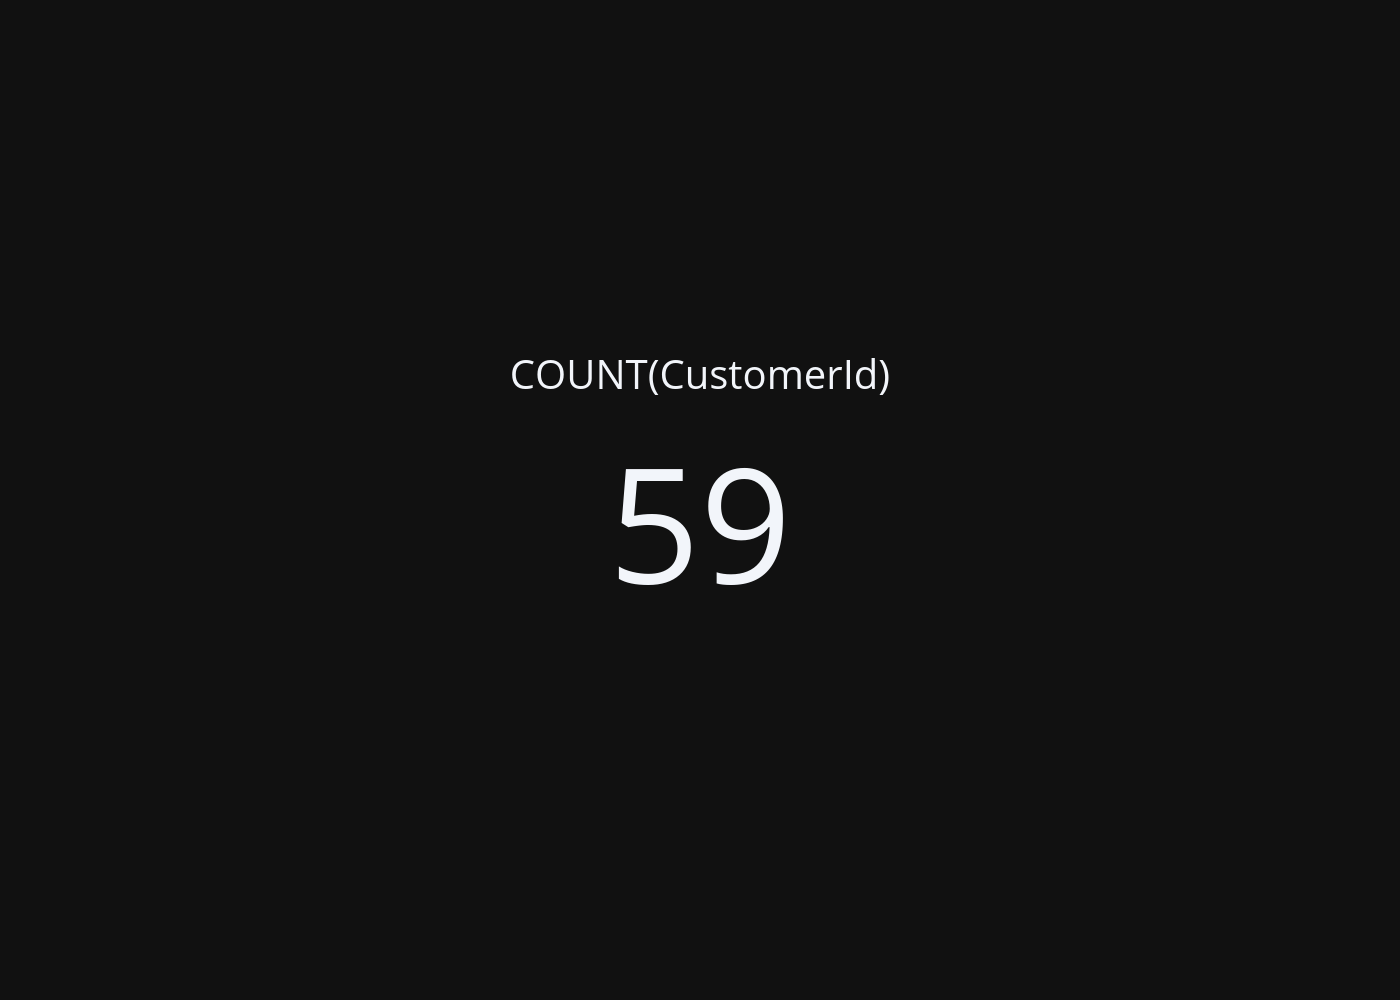

elapsed_time = 4.57498836517334


In [15]:
ts_start = time()
question = "How many customers are there"
# resp = vn.ask_adaptive(question=question)
resp = vn.ask(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

In [16]:
### Loop over questions

In [17]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]





# QUESTION  - 2:  Can you list all tables in the SQLite database catalog?



[( EXTRACTED SQL )]
SELECT
  name
FROM sqlite_master
WHERE
  type = 'table' AND name NOT LIKE 'sqlite_%';


[( <SQL> )]
generated SQL statement



SELECT
  name
FROM sqlite_master
WHERE
  type = 'table' AND name NOT LIKE 'sqlite_%';


[( <DataFrame> )]
queried dataframe



,name
0,albums
1,artists
2,customers
3,employees
4,genres
5,invoices
6,invoice_items
7,media_types
8,playlists
9,playlist_track



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Limit the DataFrame to the first 20 rows if it has more than 20
if len(df) > 20:
    df_chart = df.head(20)
else:
    df_chart = df

# Check if there is only one value in the DataFrame
if df_chart.size == 1:
    # Use an Indicator chart for a single value
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df_chart['name'].iloc[0],
        title={"text": "Table Name"}
    ))
else:
    # Use a Table chart for multiple values or an empty DataFrame
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_chart.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df_chart[col] for col in df_chart.columns],
                   fill_color='lavender',
                   align='left'))
    ])

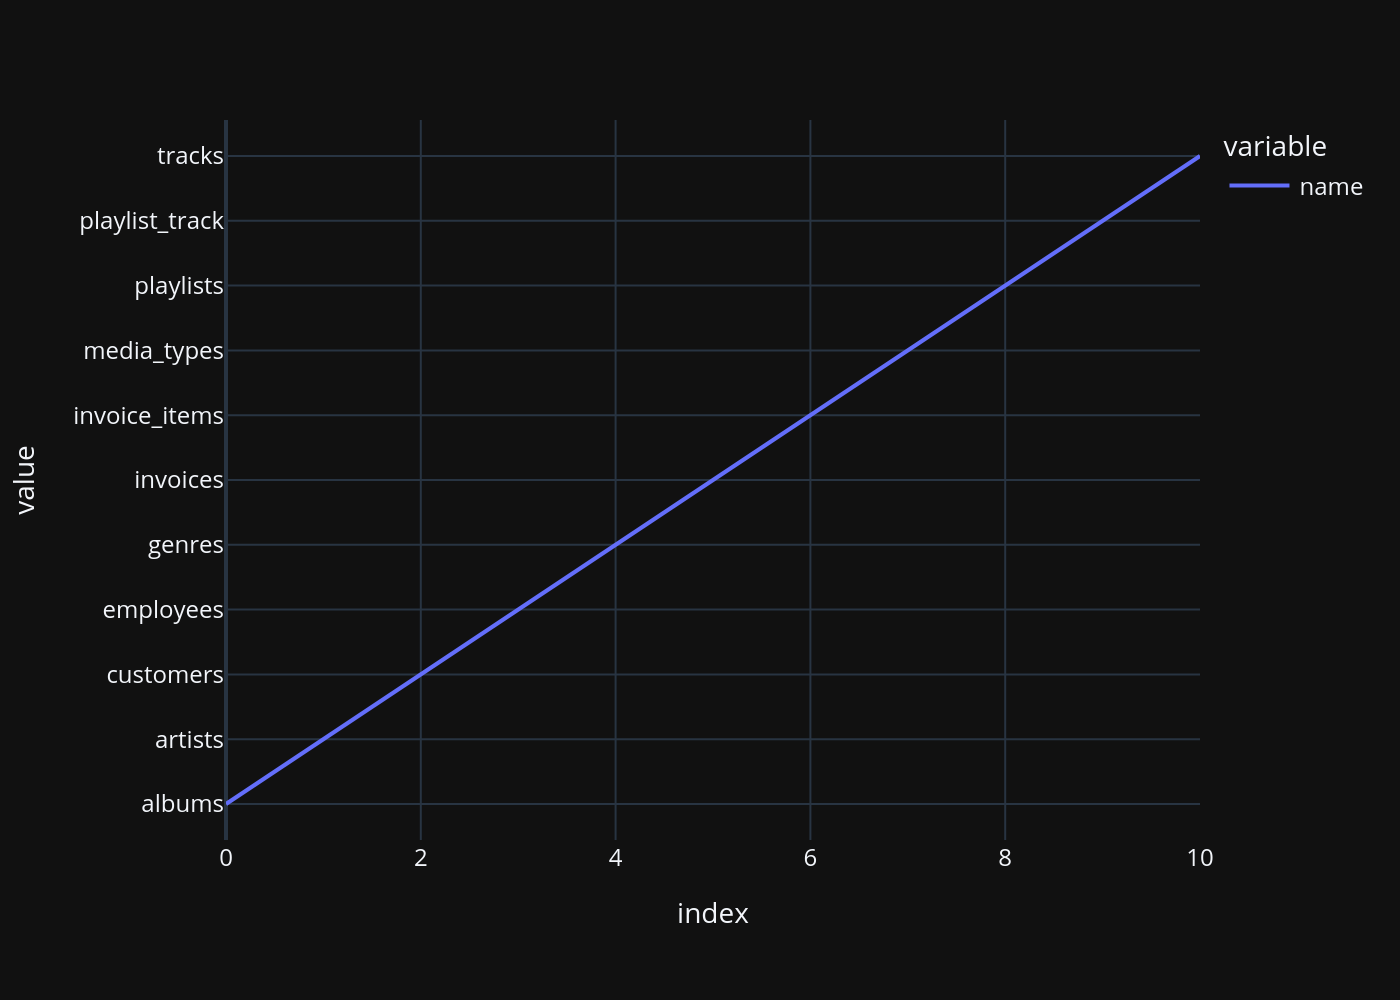





# QUESTION  - 3:  which table stores customer's orders



[( EXTRACTED SQL )]
SELECT
  name
FROM sqlite_master
WHERE
  type = 'table' AND name = 'invoices'


[( <SQL> )]
generated SQL statement



SELECT
  name
FROM sqlite_master
WHERE
  type = 'table' AND name = 'invoices'


[( <DataFrame> )]
queried dataframe



,name
0,invoices



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Limit data if more than 20 rows
df_to_chart = df.head(20) if len(df) > 20 else df

if len(df_to_chart) == 1:
    # Use an Indicator for a single value
    fig = go.Figure(go.Indicator(
        mode="text",
        value=None,
        title={
            "text": f"Table: <b>{df_to_chart['name'].iloc[0]}</b>",
            "font": {"size": 30}
        },
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
    fig.update_layout(
        title_text="Result for 'which table stores customer\'s orders'",
        title_x=0.5,
        margin=dict(l=20, r=20, t=80, b=20)
    )
elif len(df_to_chart) == 0:
    # Handle no results case
    fig = go.Figure()
    fig.add_annotation(
        text="No table found for customer orders.",
        xref="paper", yref="paper",
        x=0.5, y=0.5, showarrow=False,
        font=dict(size=20, color="gray")
    )
    fig.update_layout(
        title_text="Result for 'which table stores customer\'s orders'",
        title_x=0.5
    )
else:
    # For multiple rows, display as a table
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_to_chart.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df_to_chart[col] for col in df_to_chart.columns],
                   fill_color='lavender',
                   align='left'))
    ])
    fig.update_layout(
        title_text="Tables Found for 'which table stores customer\'s orders'",
        title_x=0.5
    )

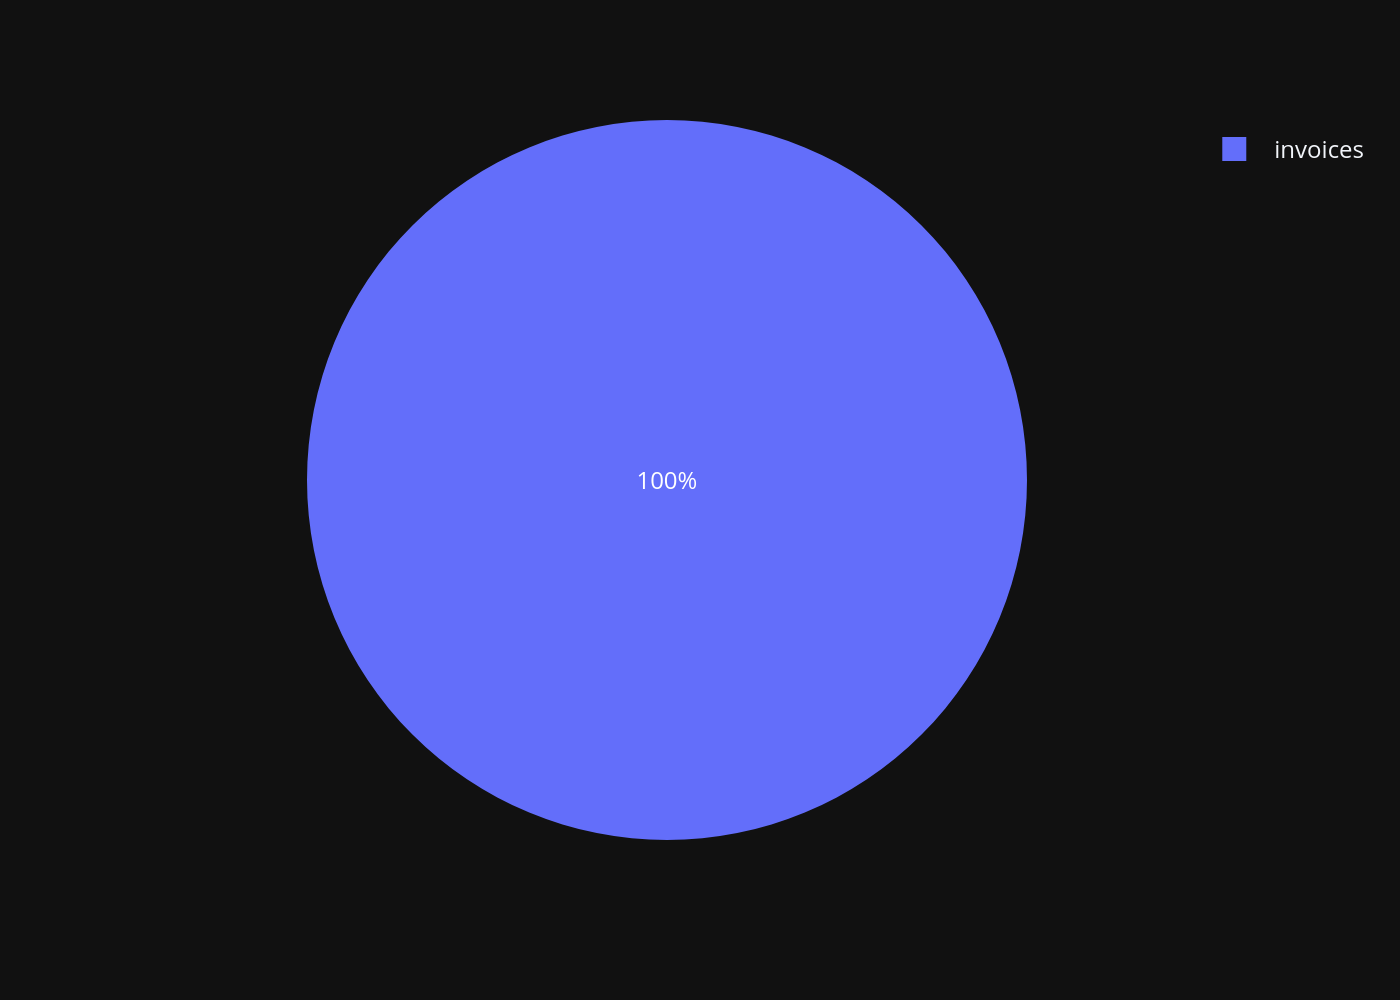





# QUESTION  - 4:  How many customers are there



[( EXTRACTED SQL )]
SELECT
  COUNT(CustomerId)
FROM customers;


[( <SQL> )]
generated SQL statement



SELECT
  COUNT(CustomerId)
FROM customers;


[( <DataFrame> )]
queried dataframe



,COUNT(CustomerId)
0,59



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Assume df is already defined as per the problem description
# For demonstration purposes, let's create a sample df that matches the description:
# df = pd.DataFrame({'COUNT(CustomerId)': [1000]})

# Check if the DataFrame has only one value
if df.shape[0] == 1 and df.shape[1] == 1:
    value = df.iloc[0, 0]
    fig = go.Figure(go.Indicator(
        mode="number",
        value=value,
        title={"text": "Number of Customers"}
    ))
else:
    # This part is not strictly necessary based on the specific query result,
    # but included for completeness based on the general instructions.
    # If there were multiple rows/columns, a different chart type would be needed.
    # For this specific query, only the Indicator path will be taken.
    # If the dataframe has more than 20 rows, use 'df.head(20)'
    data_to_chart = df.head(20) if len(df) > 20 else df

    # Determine the type of chart based on the number of columns
    if len(data_to_chart.columns) == 1:
        # If there's only one column and multiple rows, it could be a bar chart or line chart
        # For a count, a bar chart might be appropriate if there were categories,
        # but since the query is just a single count, this else block won't be hit.
        # If it were a series of counts over time, a line chart would be better.
        # As a fallback, let's assume a bar chart if this path were ever taken with 1 column, >1 row
        fig = go.Figure(data=[go.Bar(x=data_to_chart.index, y=data_to_chart.iloc[:, 0])])
        fig.update_layout(title_text=f"Chart of {data_to_chart.columns[0]}")
    elif len(data_to_chart.columns) > 1:
        # If there are multiple columns, a scatter plot or bar chart with multiple traces
        # This path is not expected for the given query.
        fig = go.Figure()
        for col in data_to_chart.columns:
            fig.add_trace(go.Scatter(x=data_to_chart.index, y=data_to_chart[col], mode='lines+markers', name=col))
        fig.update_layout(title_text="Chart of DataFrame Columns")

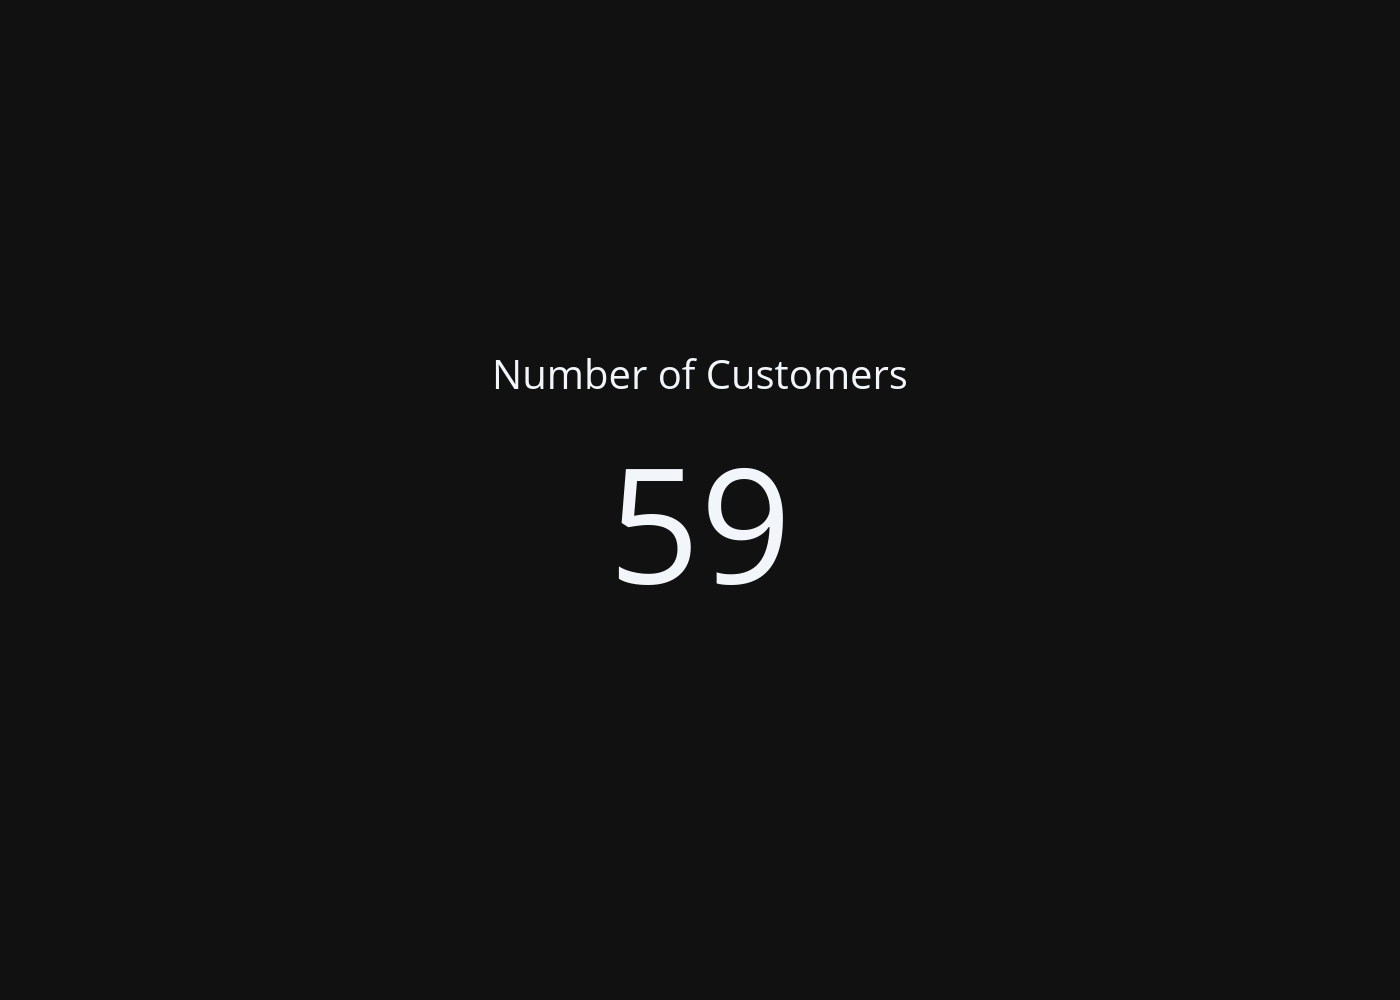





# QUESTION  - 5:  what are the top 5 countries that customers come from?



[( EXTRACTED SQL )]
SELECT
  Country,
  COUNT(CustomerId) AS NumberOfCustomers
FROM customers
GROUP BY
  Country
ORDER BY
  NumberOfCustomers DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT
  Country,
  COUNT(CustomerId) AS NumberOfCustomers
FROM customers
GROUP BY
  Country
ORDER BY
  NumberOfCustomers DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,Country,NumberOfCustomers
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].iloc[0],
        title={"text": f"Number of Customers in {df['Country'].iloc[0]}"}
    ))
else:
    # The query already limits to 5, so df.head(20) is not strictly necessary but harmless.
    # If the dataframe somehow had more than 20 rows despite the query, this would handle it.
    data_to_chart = df.head(20)

    fig = go.Figure(go.Bar(
        x=data_to_chart['Country'],
        y=data_to_chart['NumberOfCustomers'],
        marker_color='skyblue'
    ))

    fig.update_layout(
        title_text='Top Countries by Number of Customers',
        xaxis_title='Country',
        yaxis_title='Number of Customers',
        xaxis_tickangle=-45
    )

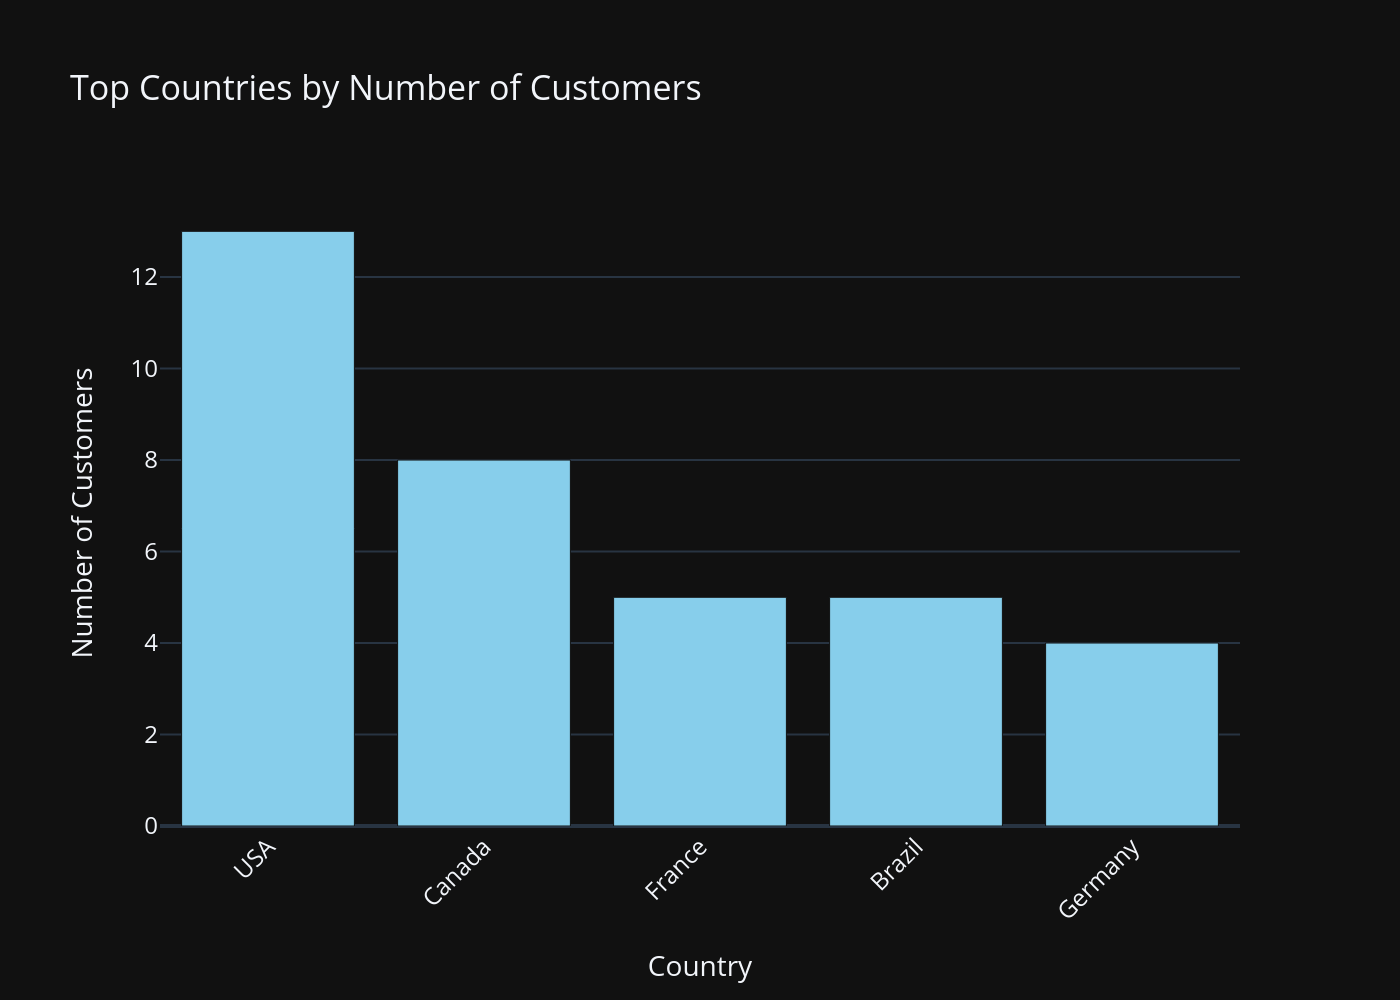





# QUESTION  - 6:  List all albums and their corresponding artist names  



[( EXTRACTED SQL )]
SELECT
  T1.Title,
  T2.Name
FROM albums AS T1
INNER JOIN artists AS T2
  ON T1.ArtistId = T2.ArtistId;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Title,
  T2.Name
FROM albums AS T1
INNER JOIN artists AS T2
  ON T1.ArtistId = T2.ArtistId;


[( <DataFrame> )]
queried dataframe



,Title,Name
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
5,Jagged Little Pill,Alanis Morissette
6,Facelift,Alice In Chains
7,Warner 25 Anos,Antônio Carlos Jobim
8,Plays Metallica By Four Cellos,Apocalyptica
9,Audioslave,Audioslave



[( <Python> )]
generated Plotly code



import plotly.graph_objects as go
import pandas as pd

df_to_chart = df.head(20)

if df_to_chart.size == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df_to_chart.iloc[0, 0]
    ))
else:
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_to_chart.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df_to_chart[col] for col in df_to_chart.columns],
                   fill_color='lavender',
                   align='left'))
    ])

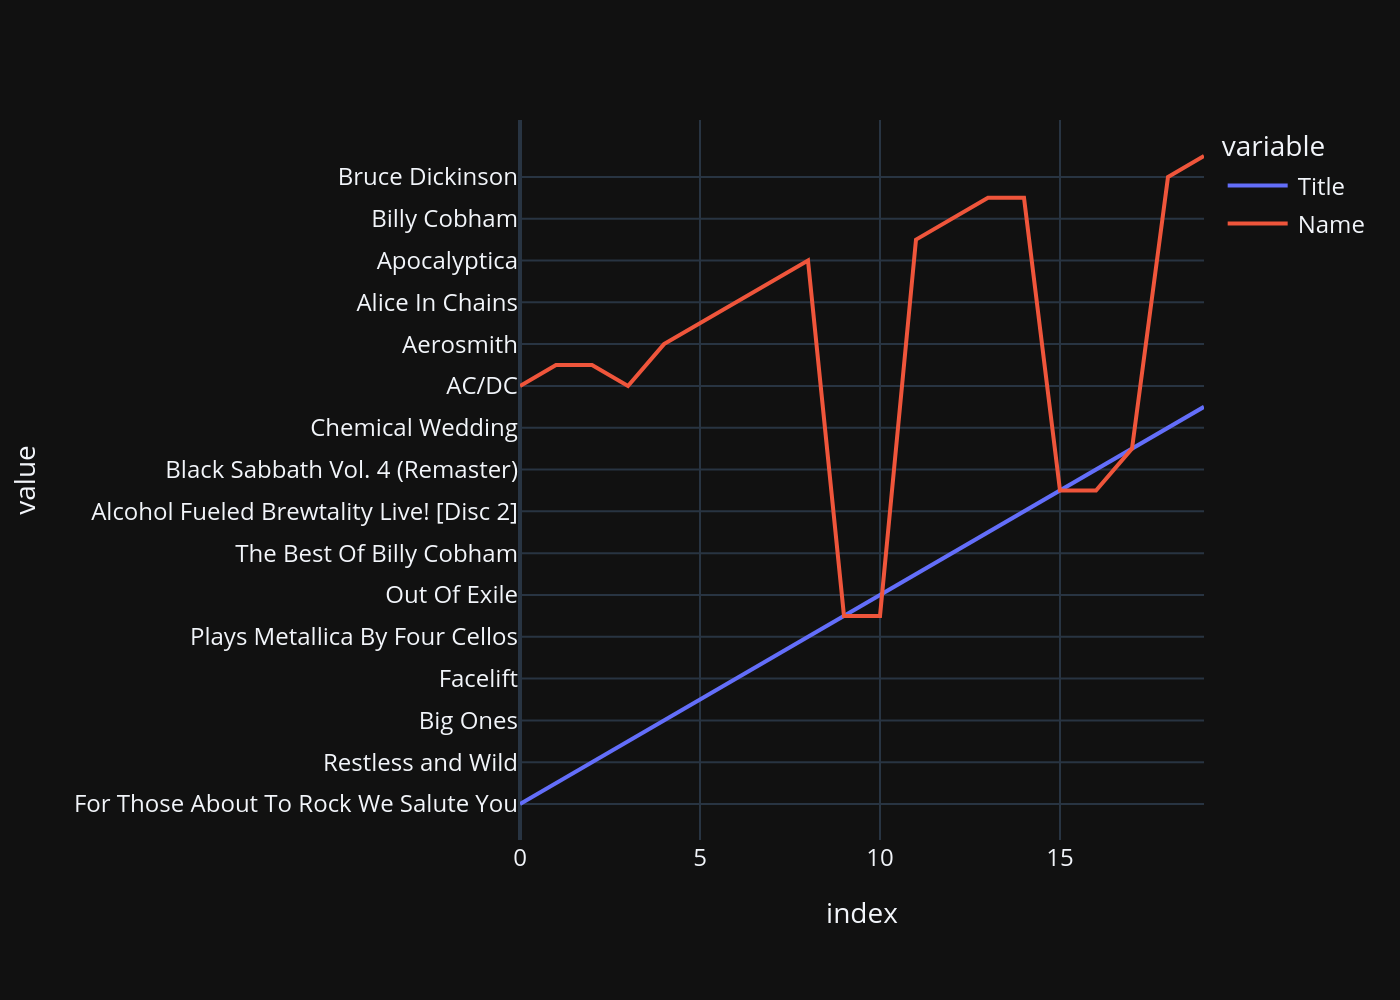





# QUESTION  - 7:  Find all tracks with a name containing "What" (case-insensitive) 


[ERROR-SQL] Failed to generate SQL for prompt: Find all tracks with a name containing "What" (case-insensitive)  with the following exception: 
429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 46
}
]

[( RETRY )]
***** 1 *****

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Find all tracks with a name containing "What" (case-insensitive) 
                    results in the following error: [ERROR-SQL] Failed to generate SQL for prompt: Find all tracks with a name containing "What" (case-insensitive)  with the following exception: 
429 You exceeded your cu

SELECT
  *
FROM tracks
WHERE
  Name LIKE '%What%' COLLATE NOCASE;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99



[( RETRY )]
***** 3 *****


[( EXTRACTED SQL )]
SELECT
  *
FROM tracks
WHERE
  Name LIKE '%What%' COLLATE NOCASE;


[( <SQL> )]
generated SQL statement



SELECT
  *
FROM tracks
WHERE
  Name LIKE '%What%' COLLATE NOCASE;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Assume df is the input DataFrame

# Limit to 20 rows as per instructions
df_to_plot = df.head(20)

# Check if the DataFrame is empty
if df_to_plot.empty:
    fig = go.Figure().add_annotation(x=0.5, y=0.5, text="No data to display.",
                                     showarrow=False, font=dict(size=20))
# Check for single value in DataFrame (single cell)
elif df_to_plot.shape == (1, 1):
    value = df_to_plot.iloc[0, 0]
    column_name = df_to_plot.columns[0]
    fig = go.Figure(go.Indicator(
        mode="number",
        value=value,
        title={"text": column_name}
    ))
# Handle multiple rows or one row with multiple columns
else:
    # Prioritize a bar chart if suitable columns exist
    if 'Name' in df_to_plot.columns and 'UnitPrice' in df_to_plot.columns:
        fig = px.bar(df_to_plot, x='Name', y='UnitPrice',
                     title='Unit Price of Tracks Containing "What"',
                     labels={'Name': 'Track Name', 'UnitPrice': 'Unit Price ($)'})
        fig.update_layout(xaxis_tickangle=-45)
    elif 'Name' in df_to_plot.columns and 'Milliseconds' in df_to_plot.columns:
        fig = px.bar(df_to_plot, x='Name', y='Milliseconds',
                     title='Duration of Tracks Containing "What"',
                     labels={'Name': 'Track Name', 'Milliseconds': 'Duration (ms)'})
        fig.update_layout(xaxis_tickangle=-45)
    elif 'Name' in df_to_plot.columns and 'Bytes' in df_to_plot.columns:
        fig = px.bar(df_to_plot, x='Name', y='Bytes',
                     title='File Size of Tracks Containing "What"',
                     labels={'Name': 'Track Name', 'Bytes': 'File Size (Bytes)'})
        fig.update_layout(xaxis_tickangle=-45)
    else:
        # Fallback to a table if no suitable columns for a bar chart
        fig = go.Figure(data=[go.Table(
            header=dict(values=list(df_to_plot.columns),
                        fill_color='paleturquoise',
                        align='left'),
            cells=dict(values=[df_to_plot[col] for col in df_to_plot.columns],
                       fill_color='lavender',
                       align='left'))
        ])

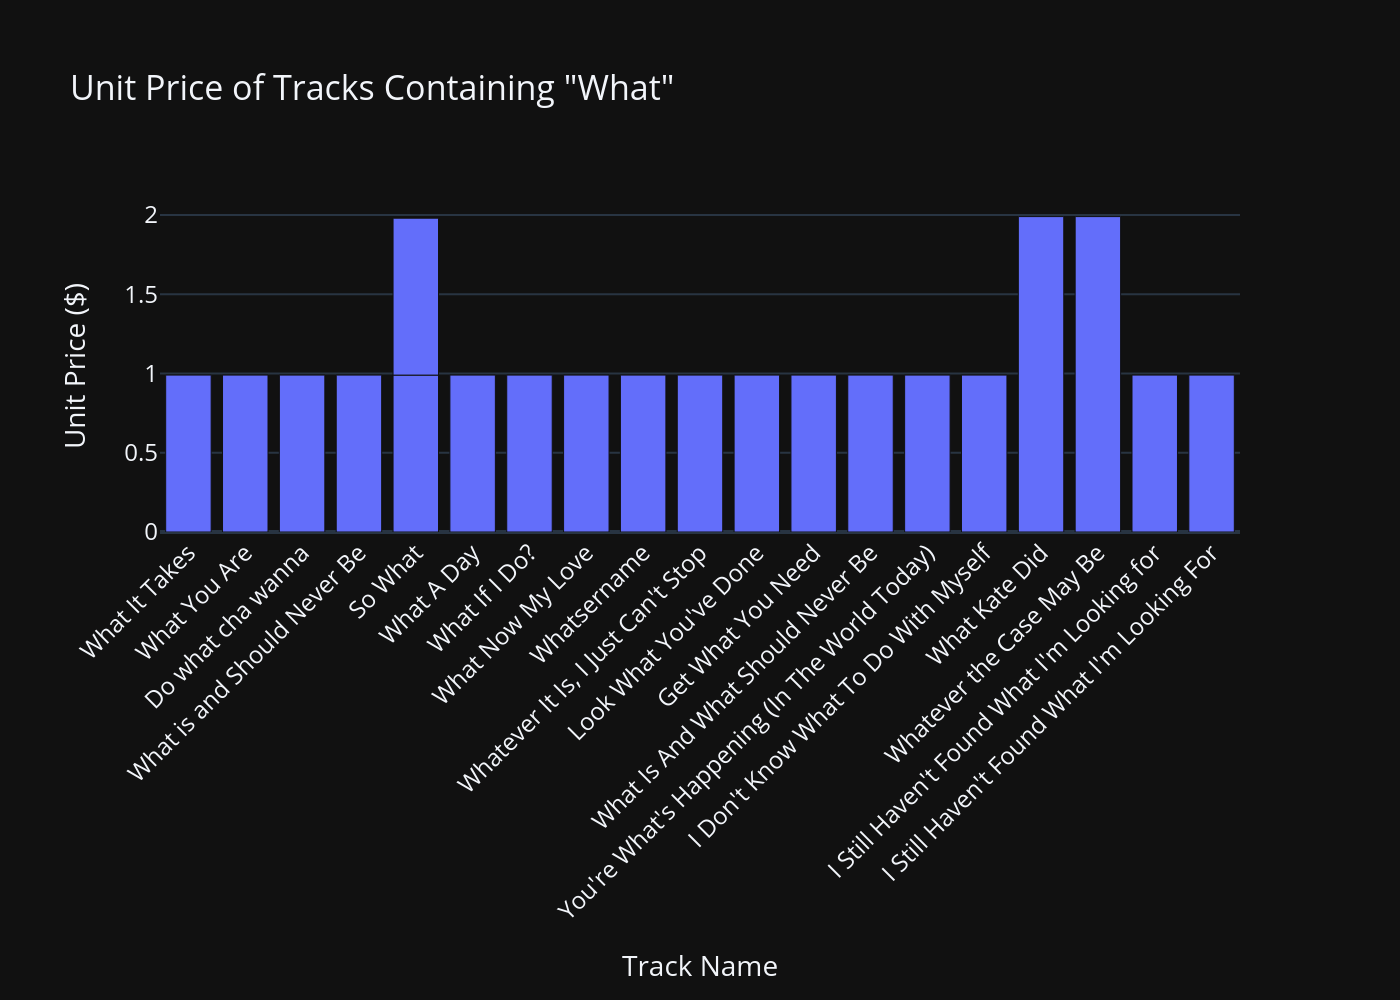





# QUESTION  - 8:  Get the total number of invoices for each customer



[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName,
  COUNT(T2.InvoiceId) AS NumberOfInvoices
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName,
  COUNT(T2.InvoiceId) AS NumberOfInvoices
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,NumberOfInvoices
0,Luís,Gonçalves,7
1,Leonie,Köhler,7
2,François,Tremblay,7
3,Bjørn,Hansen,7
4,František,Wichterlová,7
5,Helena,Holý,7
6,Astrid,Gruber,7
7,Daan,Peeters,7
8,Kara,Nielsen,7
9,Eduardo,Martins,7



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

df_to_plot = df.head(20)

if len(df_to_plot) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df_to_plot['NumberOfInvoices'].iloc[0],
        title={"text": f"Total Invoices for {df_to_plot['FirstName'].iloc[0]} {df_to_plot['LastName'].iloc[0]}"}
    ))
else:
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=df_to_plot['FirstName'] + ' ' + df_to_plot['LastName'],
        y=df_to_plot['NumberOfInvoices'],
        name='Number of Invoices',
        marker_color='skyblue'
    ))

    fig.update_layout(
        title_text='Total Number of Invoices Per Customer',
        xaxis_title='Customer Name',
        yaxis_title='Number of Invoices',
        xaxis_tickangle=-45
    )

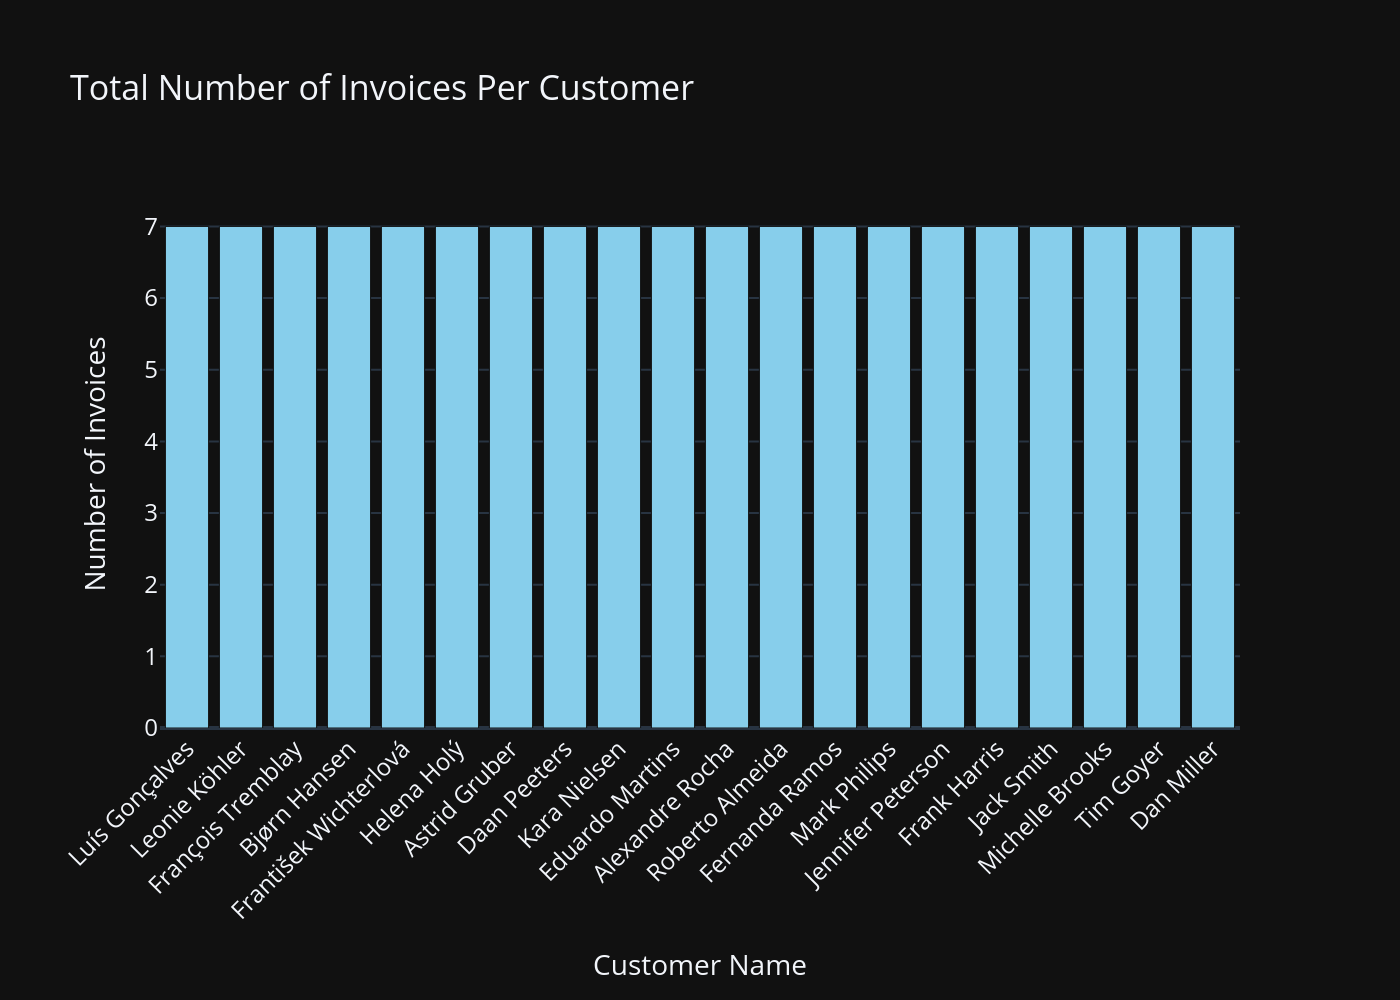





# QUESTION  - 9:  Find the total number of invoices per country



[( EXTRACTED SQL )]
SELECT
  BillingCountry,
  COUNT(InvoiceId) AS TotalInvoices
FROM invoices
GROUP BY
  BillingCountry;


[( <SQL> )]
generated SQL statement



SELECT
  BillingCountry,
  COUNT(InvoiceId) AS TotalInvoices
FROM invoices
GROUP BY
  BillingCountry;


[( <DataFrame> )]
queried dataframe



,BillingCountry,TotalInvoices
0,Argentina,7
1,Australia,7
2,Austria,7
3,Belgium,7
4,Brazil,35
5,Canada,56
6,Chile,7
7,Czech Republic,14
8,Denmark,7
9,Finland,7



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

if len(df) == 1:
    country = df['BillingCountry'].iloc[0]
    total_invoices = df['TotalInvoices'].iloc[0]
    fig = go.Figure(go.Indicator(
        mode="number",
        value=total_invoices,
        title={"text": f"Total Invoices for {country}"}
    ))
else:
    if len(df) > 20:
        df_to_chart = df.head(20)
    else:
        df_to_chart = df

    fig = px.bar(df_to_chart,
                 x='BillingCountry',
                 y='TotalInvoices',
                 title='Total Invoices per Country',
                 labels={'BillingCountry': 'Country', 'TotalInvoices': 'Total Invoices'},
                 text='TotalInvoices')
    fig.update_traces(texttemplate='%{text}', textposition='outside')
    fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')

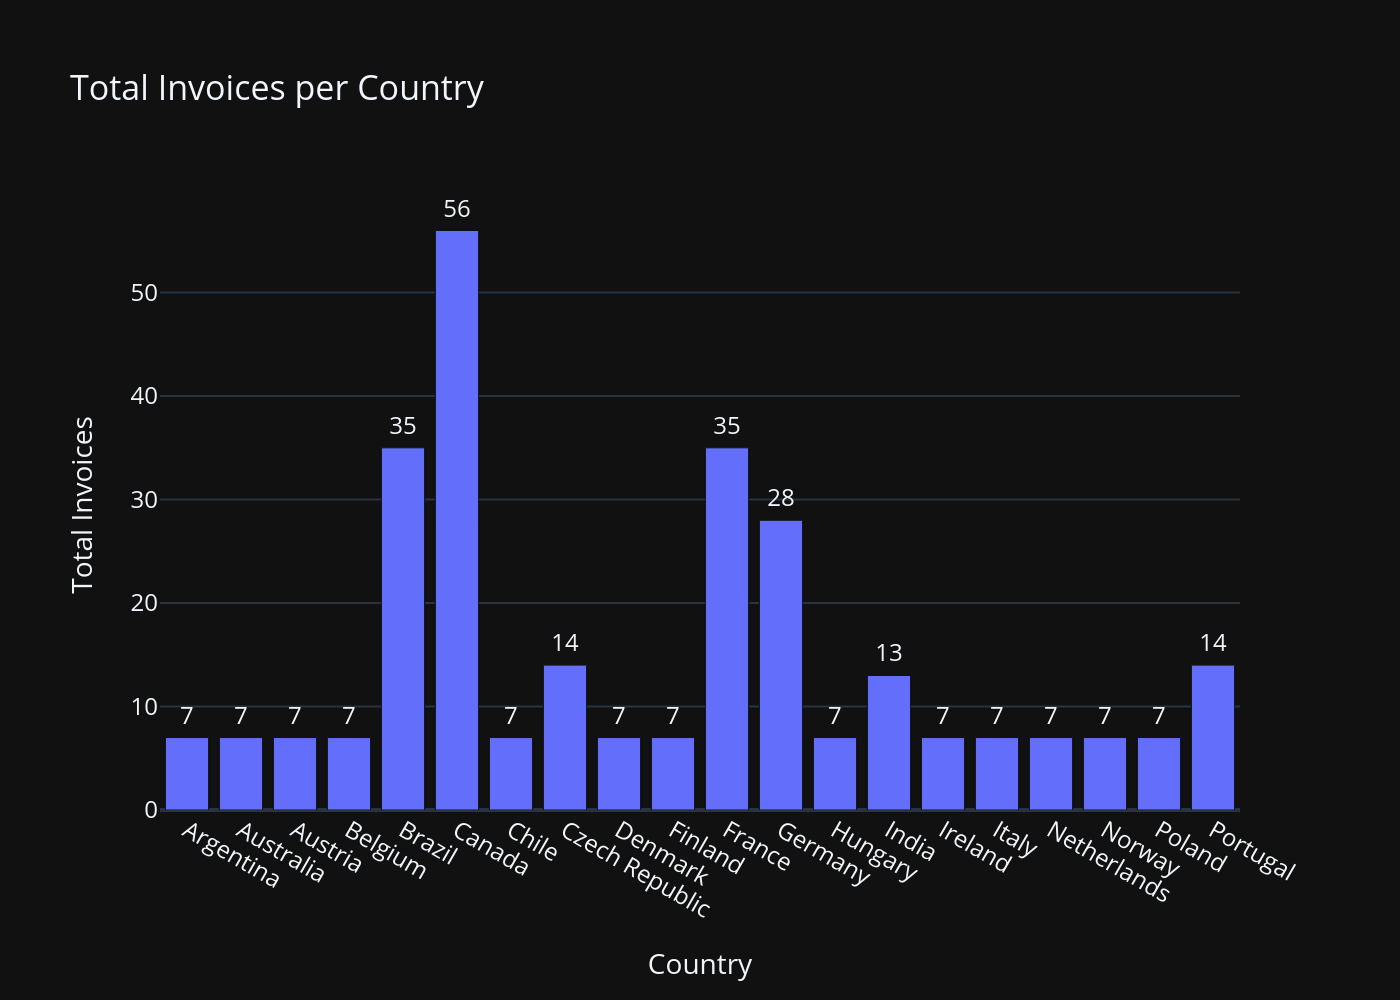





# QUESTION  - 10:  List all invoices with a total exceeding $10



[( EXTRACTED SQL )]
SELECT
  *
FROM invoices
WHERE
  Total > 10;


[( <SQL> )]
generated SQL statement



SELECT
  *
FROM invoices
WHERE
  Total > 10;


[( <DataFrame> )]
queried dataframe



,InvoiceId,CustomerId,InvoiceDate,BillingAddress,BillingCity,BillingState,BillingCountry,BillingPostalCode,Total
0,5,23,2009-01-11 00:00:00,69 Salem Street,Boston,MA,USA,2113,13.86
1,12,2,2009-02-11 00:00:00,Theodor-Heuss-Straße 34,Stuttgart,None,Germany,70174,13.86
2,19,40,2009-03-14 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,13.86
3,26,19,2009-04-14 00:00:00,1 Infinite Loop,Cupertino,CA,USA,95014,13.86
4,33,57,2009-05-15 00:00:00,"Calle Lira, 198",Santiago,None,Chile,None,13.86
5,40,36,2009-06-15 00:00:00,Tauentzienstraße 8,Berlin,None,Germany,10789,13.86
6,47,15,2009-07-16 00:00:00,700 W Pender Street,Vancouver,BC,Canada,V6C 1G8,13.86
7,54,53,2009-08-16 00:00:00,113 Lupus St,London,None,United Kingdom,SW1V 3EN,13.86
8,61,32,2009-09-16 00:00:00,696 Osborne Street,Winnipeg,MB,Canada,R3L 2B9,13.86
9,68,11,2009-10-17 00:00:00,"Av. Paulista, 2022",São Paulo,SP,Brazil,01310-200,13.86



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

df_to_plot = df.head(20)

if df_to_plot.empty:
    fig = go.Figure()
    fig.add_annotation(
        text="No data to display for invoices exceeding $10.",
        xref="paper", yref="paper",
        showarrow=False,
        font=dict(size=16)
    )
    fig.update_layout(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        height=300,
        width=500
    )
elif df_to_plot.shape[0] == 1:
    total_value = df_to_plot['Total'].iloc[0]
    invoice_id = df_to_plot['InvoiceId'].iloc[0]
    fig = go.Figure(go.Indicator(
        mode="number",
        value=total_value,
        title={"text": f"Total for Invoice ID: {invoice_id}"},
        number={"prefix": "$"}
    ))
    fig.update_layout(height=250, width=400)
else:
    fig = px.bar(
        df_to_plot,
        x='InvoiceId',
        y='Total',
        title='Invoices with Total Exceeding $10',
        labels={'InvoiceId': 'Invoice ID', 'Total': 'Total Amount ($)'},
        hover_data=['InvoiceDate', 'CustomerId', 'BillingCountry', 'BillingCity']
    )
    fig.update_layout(xaxis_tickangle=-45)

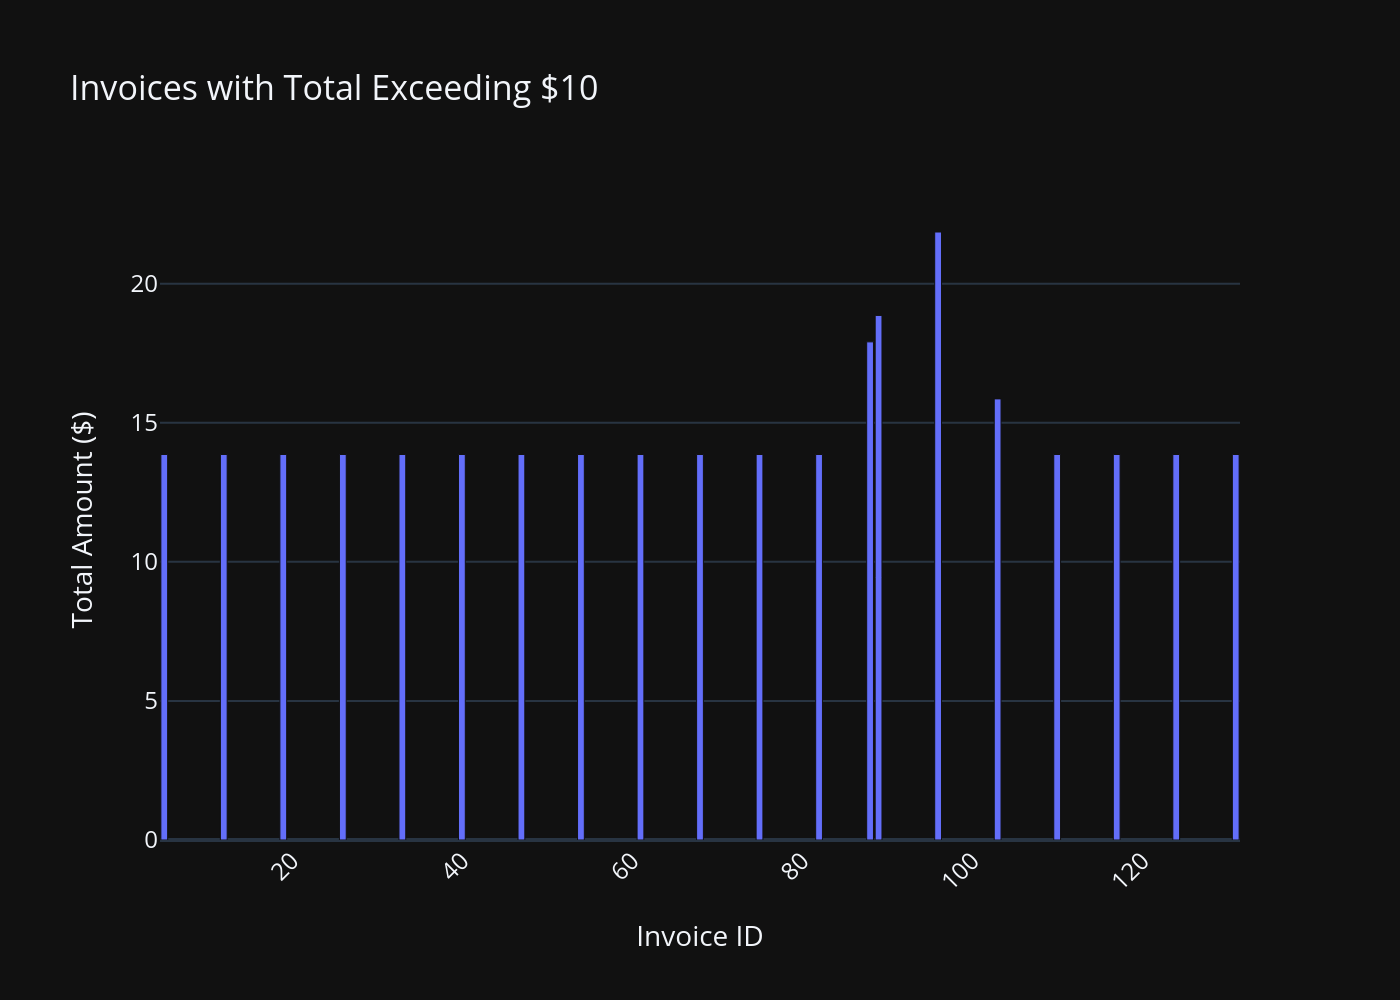





# QUESTION  - 11:  Find all invoices since 2010 and the total amount invoiced:



[( EXTRACTED SQL )]
SELECT
  InvoiceId,
  InvoiceDate,
  Total
FROM invoices
WHERE
  InvoiceDate >= '2010-01-01'


[( <SQL> )]
generated SQL statement



SELECT
  InvoiceId,
  InvoiceDate,
  Total
FROM invoices
WHERE
  InvoiceDate >= '2010-01-01'


[( <DataFrame> )]
queried dataframe



,InvoiceId,InvoiceDate,Total
0,84,2010-01-08 00:00:00,1.98
1,85,2010-01-08 00:00:00,1.98
2,86,2010-01-09 00:00:00,3.96
3,87,2010-01-10 00:00:00,6.94
4,88,2010-01-13 00:00:00,17.91
5,89,2010-01-18 00:00:00,18.86
6,90,2010-01-26 00:00:00,0.99
7,91,2010-02-08 00:00:00,1.98
8,92,2010-02-08 00:00:00,1.98
9,93,2010-02-09 00:00:00,3.96



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Limit the DataFrame to the first 20 rows as specified.
# The original query already limits to 20, so this ensures consistency.
df_to_plot = df.head(20)

# Convert 'InvoiceDate' to datetime objects for proper time-series plotting.
if 'InvoiceDate' in df_to_plot.columns and df_to_plot['InvoiceDate'].dtype == 'object':
    df_to_plot['InvoiceDate'] = pd.to_datetime(df_to_plot['InvoiceDate'])

if len(df_to_plot) == 0:
    # If the DataFrame is empty, display a message.
    fig = go.Figure()
    fig.add_annotation(text="No data available for the selected criteria.",
                       xref="paper", yref="paper",
                       x=0.5, y=0.5, showarrow=False,
                       font=dict(size=16))
    fig.update_layout(
        height=300,
        xaxis={'visible': False},
        yaxis={'visible': False}
    )
elif len(df_to_plot) == 1:
    # If there's only one row, use an Indicator chart.
    total_value = df_to_plot['Total'].iloc[0]
    fig = go.Figure(go.Indicator(
        mode="number",
        value=total_value,
        title={"text": "Total Invoiced Amount"}
    ))
    fig.update_layout(
        margin=dict(l=20, r=20, t=50, b=20),
        height=200
    )
else:
    # For multiple rows, create a line chart to show invoice totals over time.
    fig = px.line(df_to_plot,
                  x='InvoiceDate',
                  y='Total',
                  title='Invoice Totals Over Time',
                  labels={'InvoiceDate': 'Invoice Date', 'Total': 'Total Amount'},
                  hover_data=['InvoiceId', 'Total']) # Include InvoiceId in hover info

    fig.update_traces(mode='lines+markers') # Show markers for individual invoices
    fig.update_layout(hovermode="x unified") # Improve hover experience

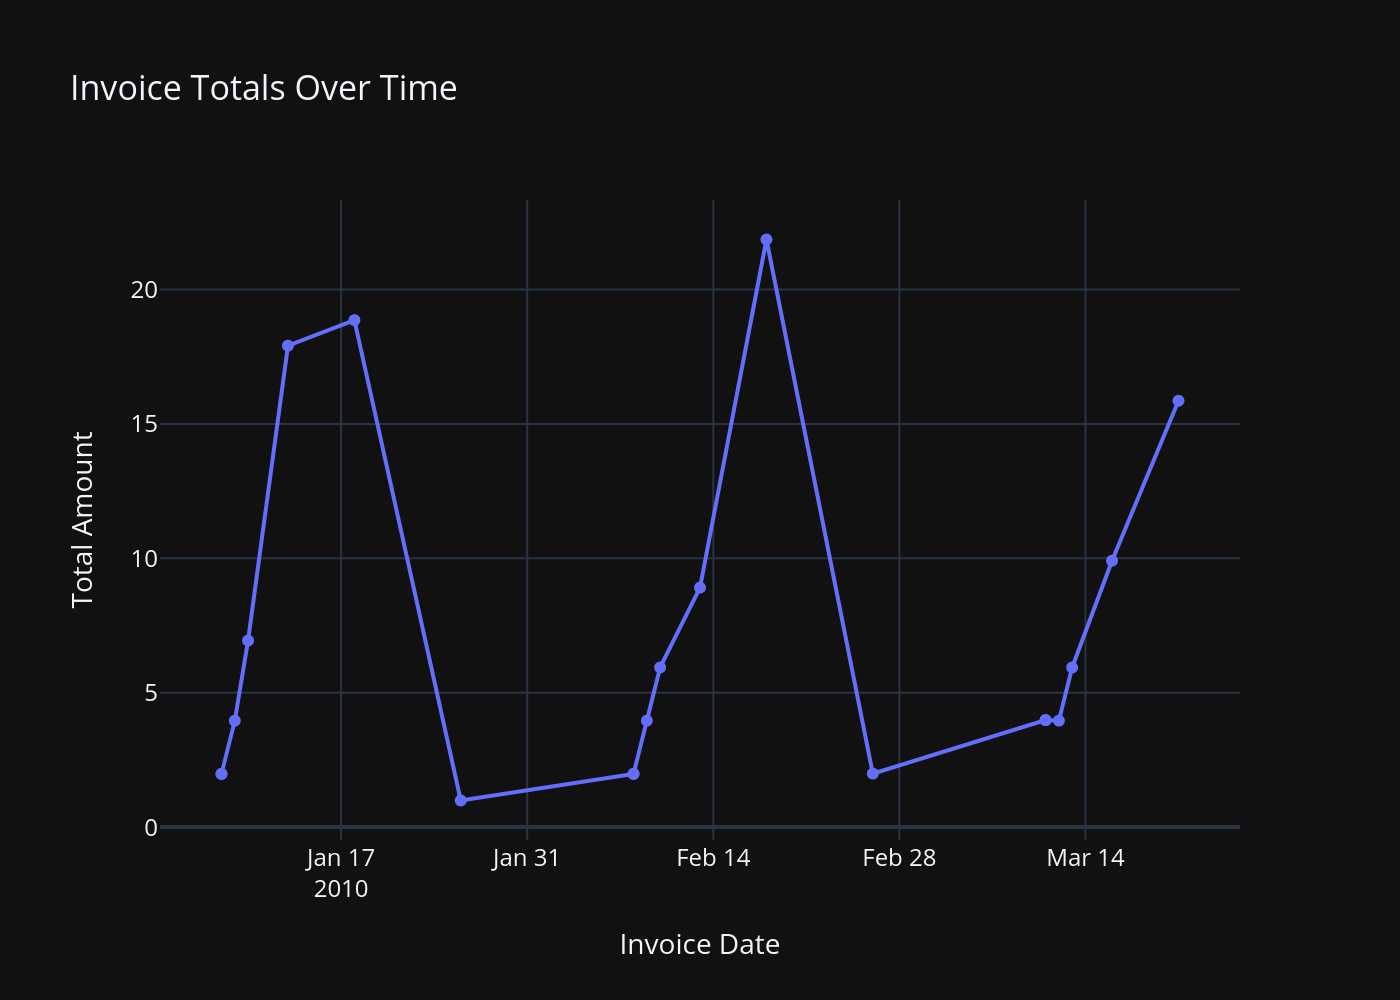





# QUESTION  - 12:  List all employees and their reporting manager's name (if any):



[( EXTRACTED SQL )]
SELECT
  E.FirstName,
  E.LastName,
  M.FirstName AS ManagerFirstName,
  M.LastName AS ManagerLastName
FROM employees AS E
LEFT JOIN employees AS M
  ON E.ReportsTo = M.EmployeeId;


[( <SQL> )]
generated SQL statement



SELECT
  E.FirstName,
  E.LastName,
  M.FirstName AS ManagerFirstName,
  M.LastName AS ManagerLastName
FROM employees AS E
LEFT JOIN employees AS M
  ON E.ReportsTo = M.EmployeeId;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,ManagerFirstName,ManagerLastName
0,Andrew,Adams,None,None
1,Nancy,Edwards,Andrew,Adams
2,Jane,Peacock,Nancy,Edwards
3,Margaret,Park,Nancy,Edwards
4,Steve,Johnson,Nancy,Edwards
5,Michael,Mitchell,Andrew,Adams
6,Robert,King,Michael,Mitchell
7,Laura,Callahan,Michael,Mitchell



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

df_to_chart = df.head(20)

fig = go.Figure(data=[go.Table(
    header=dict(values=['Employee First Name', 'Employee Last Name', 'Manager First Name', 'Manager Last Name'],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[df_to_chart['FirstName'], df_to_chart['LastName'],
                       df_to_chart['ManagerFirstName'], df_to_chart['ManagerLastName']],
               fill_color='lavender',
               align='left'))
])

fig.update_layout(title_text="Employees and Their Reporting Managers")

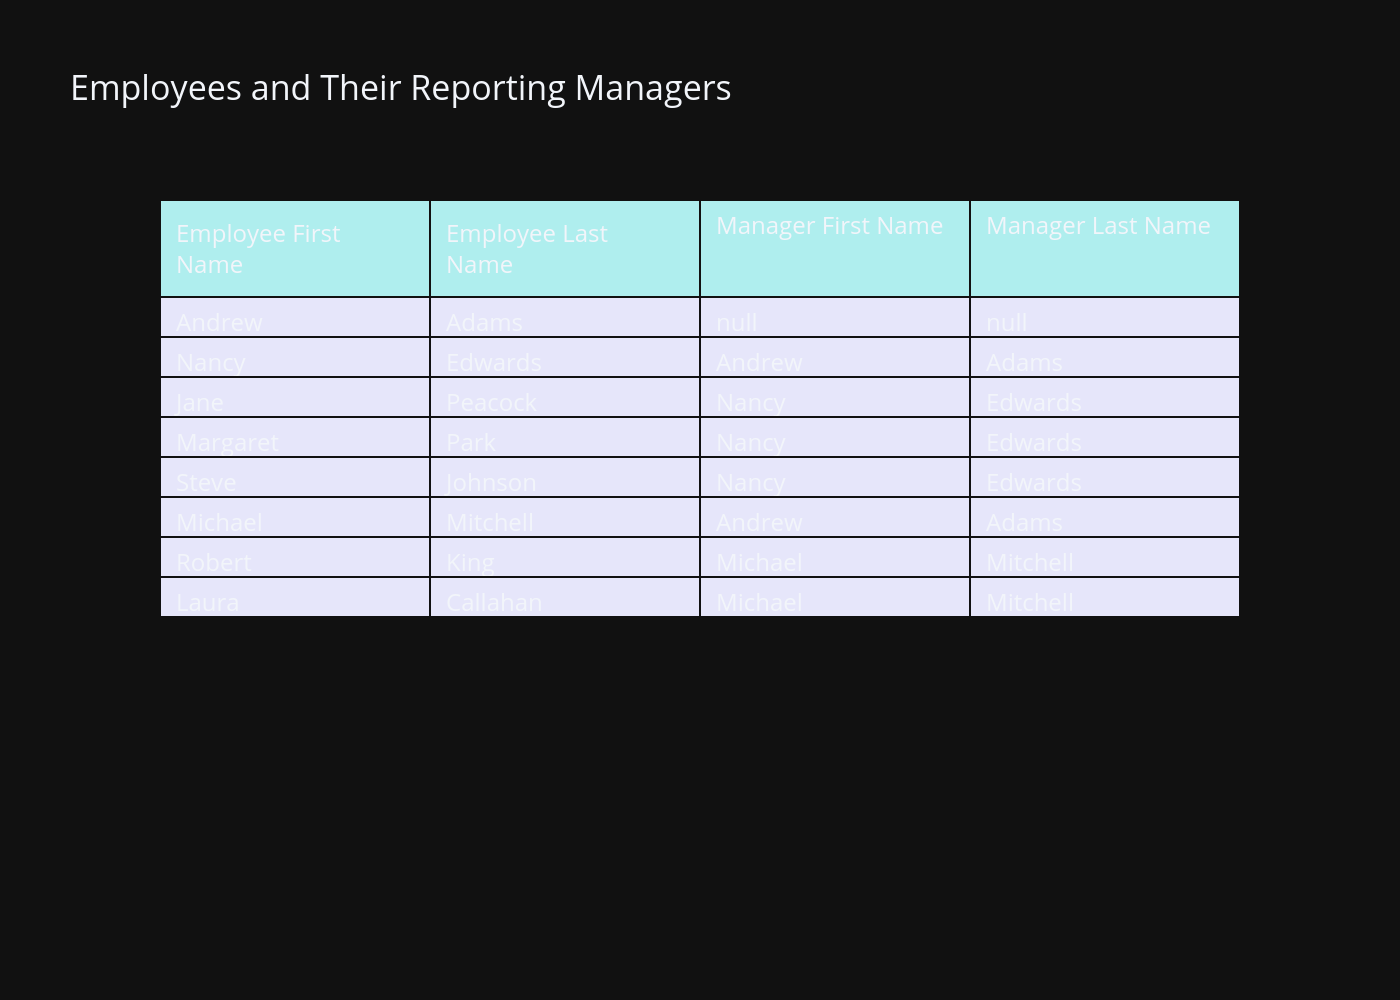





# QUESTION  - 13:   Get the average invoice total for each customer:



[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName,
  AVG(T2.Total) AS AverageInvoiceTotal
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName,
  AVG(T2.Total) AS AverageInvoiceTotal
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,AverageInvoiceTotal
0,Luís,Gonçalves,5.660000
1,Leonie,Köhler,5.374286
2,François,Tremblay,5.660000
3,Bjørn,Hansen,5.660000
4,František,Wichterlová,5.802857
5,Helena,Holý,7.088571
6,Astrid,Gruber,6.088571
7,Daan,Peeters,5.374286
8,Kara,Nielsen,5.374286
9,Eduardo,Martins,5.374286



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['AverageInvoiceTotal'].iloc[0],
        title={"text": "Average Invoice Total"}
    ))
else:
    df_to_plot = df.head(20)
    df_to_plot['CustomerName'] = df_to_plot['FirstName'] + ' ' + df_to_plot['LastName']

    fig = px.bar(
        df_to_plot,
        x='CustomerName',
        y='AverageInvoiceTotal',
        title='Average Invoice Total per Customer',
        labels={
            'CustomerName': 'Customer',
            'AverageInvoiceTotal': 'Average Invoice Total ($)'
        }
    )
    fig.update_layout(xaxis_tickangle=-45)

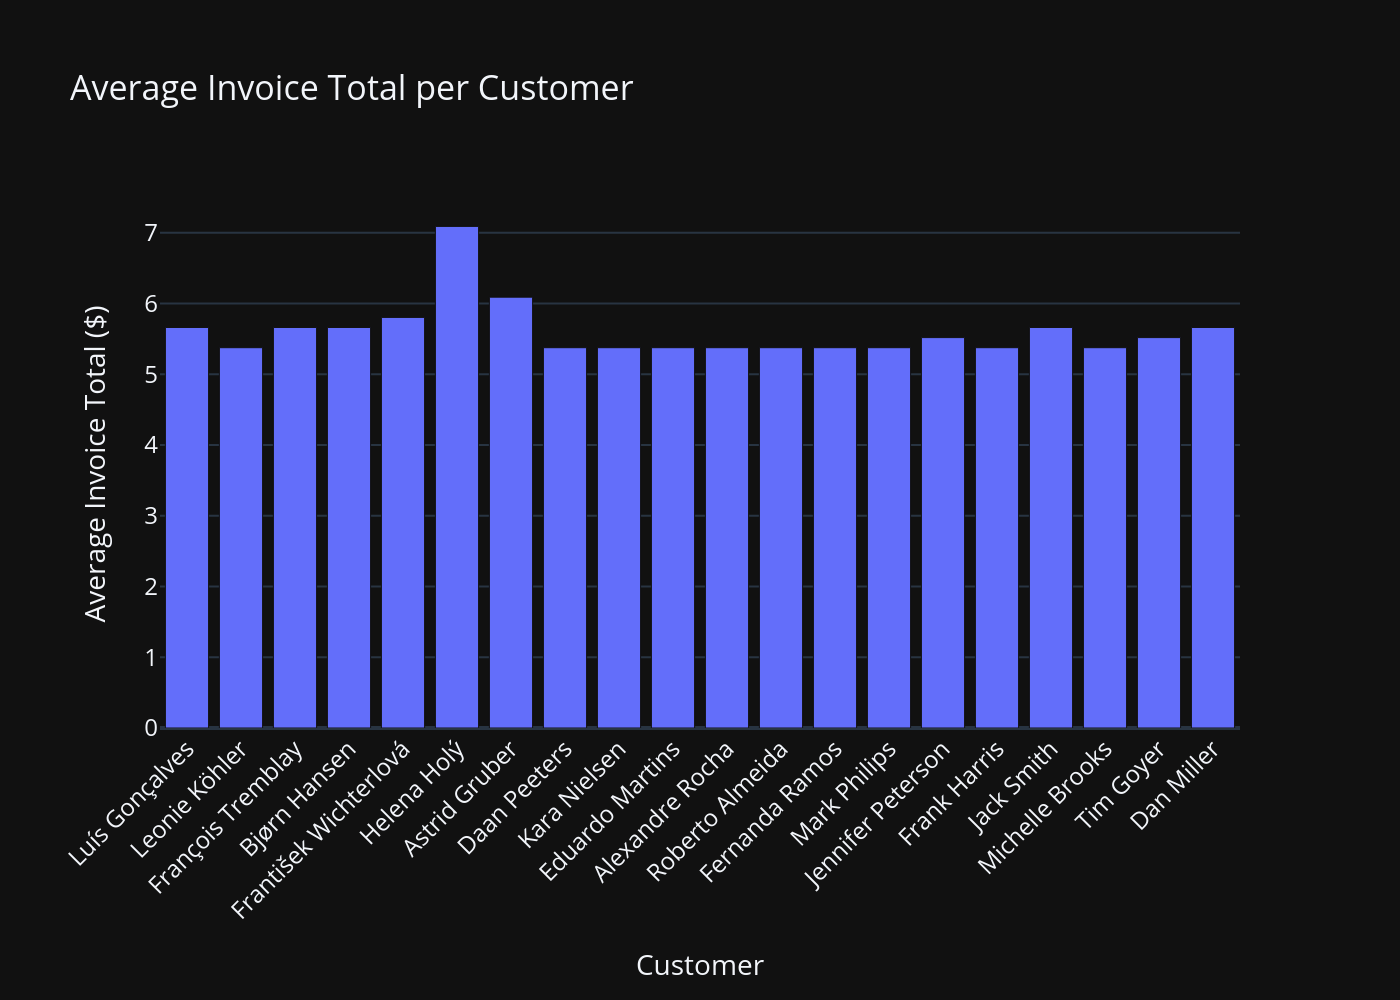





# QUESTION  - 14:  Find the top 5 most expensive tracks (based on unit price):




<string>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




[( EXTRACTED SQL )]
SELECT
  TrackId,
  Name,
  UnitPrice
FROM tracks
ORDER BY
  UnitPrice DESC
LIMIT 5;


[( <SQL> )]
generated SQL statement



SELECT
  TrackId,
  Name,
  UnitPrice
FROM tracks
ORDER BY
  UnitPrice DESC
LIMIT 5;


[( <DataFrame> )]
queried dataframe



,TrackId,Name,UnitPrice
0,2819,Battlestar Galactica: The Story So Far,1.99
1,2820,Occupation / Precipice,1.99
2,2821,"Exodus, Pt. 1",1.99
3,2822,"Exodus, Pt. 2",1.99
4,2823,Collaborators,1.99



[( <Python> )]
generated Plotly code



import plotly.express as px
import pandas as pd

# Assuming 'df' is the DataFrame as described
# Example df structure based on the query:
# df = pd.DataFrame({
#     'TrackId': [123, 456, 789, 101, 112],
#     'Name': ['Track A', 'Track B', 'Track C', 'Track D', 'Track E'],
#     'UnitPrice': [1.99, 1.29, 0.99, 0.79, 0.69]
# })

if len(df) == 1:
    fig = px.indicator(
        value=df.iloc[0]['UnitPrice'],
        title=f"Unit Price for {df.iloc[0]['Name']}"
    )
elif len(df) > 20:
    df_to_chart = df.head(20)
    fig = px.bar(df_to_chart,
                 x='Name',
                 y='UnitPrice',
                 title='Top 20 Most Expensive Tracks',
                 labels={'Name': 'Track Name', 'UnitPrice': 'Unit Price'})
else:
    fig = px.bar(df,
                 x='Name',
                 y='UnitPrice',
                 title='Top 5 Most Expensive Tracks',
                 labels={'Name': 'Track Name', 'UnitPrice': 'Unit Price'})

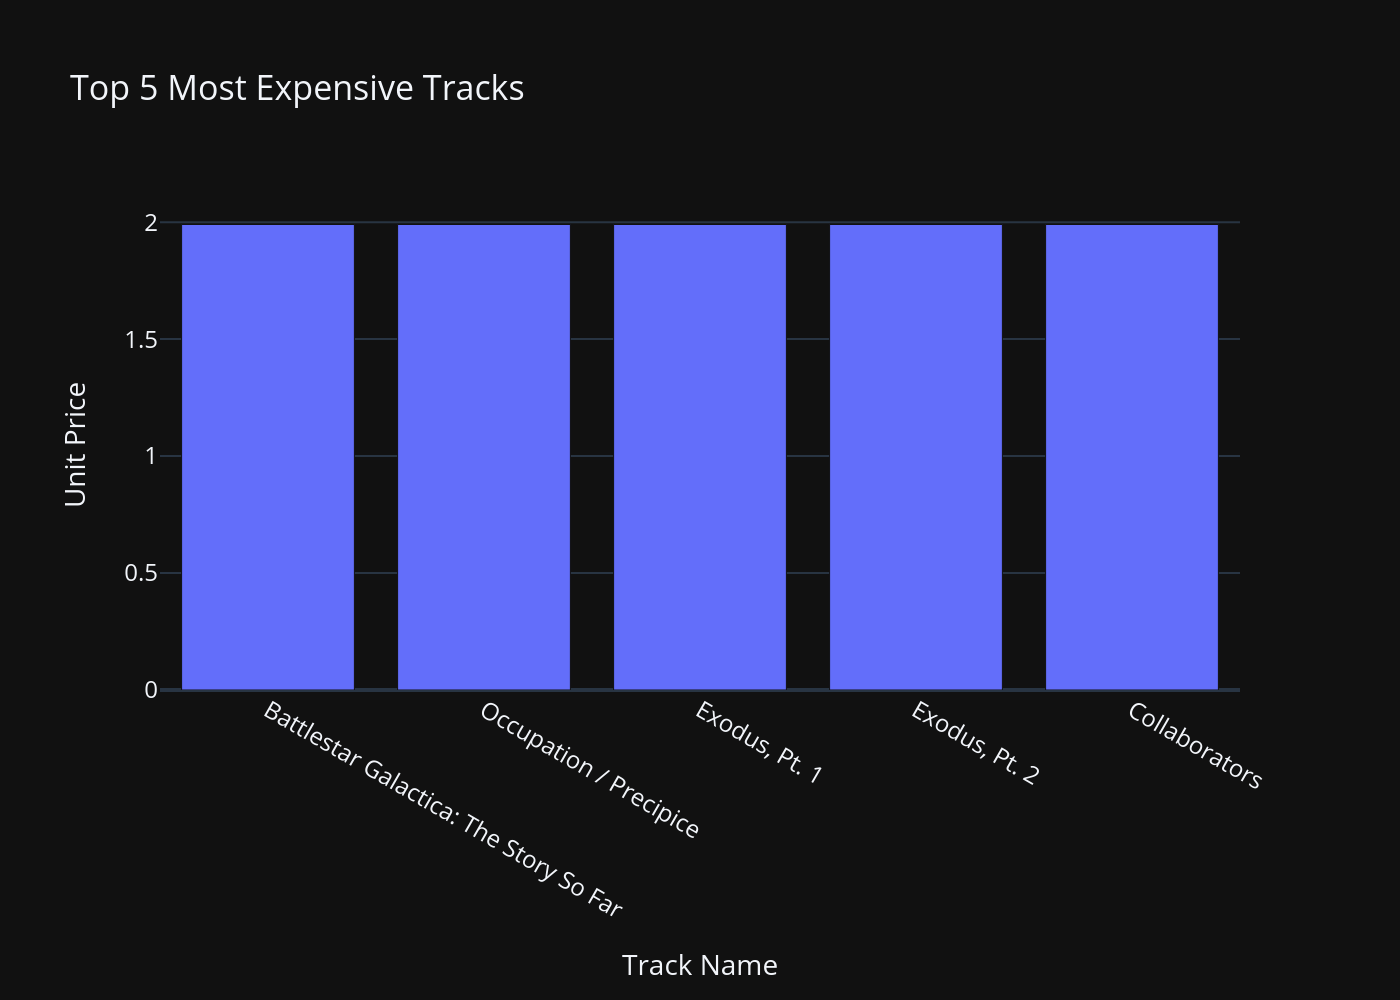





# QUESTION  - 15:  List all genres and the number of tracks in each genre:



[( EXTRACTED SQL )]
SELECT
  T1.Name,
  COUNT(T2.TrackId) AS NumberOfTracks
FROM genres AS T1
INNER JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
GROUP BY
  T1.Name;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name,
  COUNT(T2.TrackId) AS NumberOfTracks
FROM genres AS T1
INNER JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
GROUP BY
  T1.Name;


[( <DataFrame> )]
queried dataframe



,Name,NumberOfTracks
0,Alternative,40
1,Alternative & Punk,332
2,Blues,81
3,Bossa Nova,15
4,Classical,74
5,Comedy,17
6,Drama,64
7,Easy Listening,24
8,Electronica/Dance,30
9,Heavy Metal,28



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

if len(df) > 20:
    df = df.head(20)

if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfTracks'].iloc[0],
        title={'text': f"Number of Tracks in {df['Name'].iloc[0]}"}
    ))
else:
    fig = px.bar(df,
                 x='Name',
                 y='NumberOfTracks',
                 title='Number of Tracks per Genre',
                 labels={'Name': 'Genre', 'NumberOfTracks': 'Number of Tracks'})

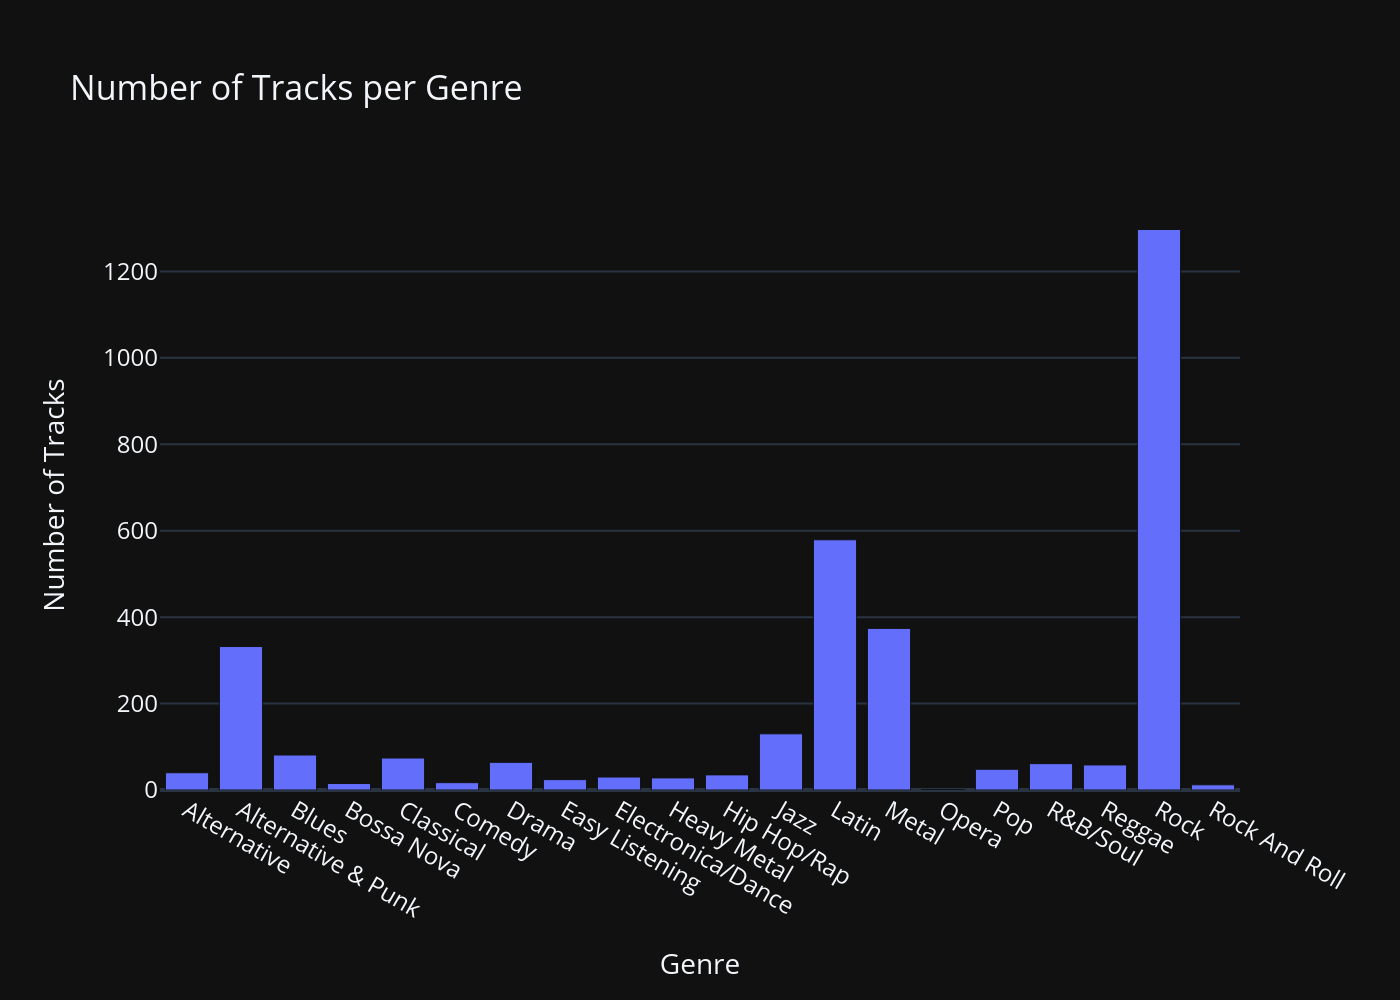





# QUESTION  - 16:  Get all genres that do not have any tracks associated with them:



[( EXTRACTED SQL )]
SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 1 *****


[( EXTRACTED SQL )]
SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 2 *****


[( EXTRACTED SQL )]
SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,Name



[( RETRY )]
***** 3 *****


[( EXTRACTED SQL )]
SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name
FROM genres AS T1
LEFT JOIN tracks AS T2
  ON T1.GenreId = T2.GenreId
WHERE
  T2.TrackId IS NULL;


[( <DataFrame> )]
queried dataframe



,Name






# QUESTION  - 17:  List all customers who have not placed any orders:



[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName



[( RETRY )]
***** 1 *****


[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName



[( RETRY )]
***** 2 *****


[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName



[( RETRY )]
***** 3 *****


[( EXTRACTED SQL )]
SELECT
  T1.CustomerId,
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <SQL> )]
generated SQL statement



SELECT
  T1.CustomerId,
  T1.FirstName,
  T1.LastName
FROM customers AS T1
LEFT JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
WHERE
  T2.InvoiceId IS NULL;


[( <DataFrame> )]
queried dataframe



,CustomerId,FirstName,LastName






# QUESTION  - 18:   
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    



[( EXTRACTED SQL )]
SELECT
  T1.Name,
  COUNT(T3.TrackId) AS NumberOfTracks
FROM artists AS T1
INNER JOIN albums AS T2
  ON T1.ArtistId = T2.ArtistId
INNER JOIN tracks AS T3
  ON T2.AlbumId = T3.AlbumId
GROUP BY
  T1.Name
ORDER BY
  NumberOfTracks DESC
LIMIT 10;


[( <SQL> )]
generated SQL statement



SELECT
  T1.Name,
  COUNT(T3.TrackId) AS NumberOfTracks
FROM artists AS T1
INNER JOIN albums AS T2
  ON T1.ArtistId = T2.ArtistId
INNER JOIN tracks AS T3
  ON T2.AlbumId = T3.AlbumId
GROUP BY
  T1.Name
ORDER BY
  NumberOfTracks DESC
LIMIT 10;


[( <DataFrame> )]
queried dataframe



,Name,NumberOfTracks
0,Iron Maiden,213
1,U2,135
2,Led Zeppelin,114
3,Metallica,112
4,Lost,92
5,Deep Purple,92
6,Pearl Jam,67
7,Lenny Kravitz,57
8,Various Artists,56
9,The Office,53



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

data_to_chart = df.head(20)

if len(data_to_chart) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=data_to_chart['NumberOfTracks'].iloc[0],
        title={"text": f"Number of Tracks for {data_to_chart['Name'].iloc[0]}"}
    ))
else:
    fig = px.bar(
        data_to_chart,
        x='Name',
        y='NumberOfTracks',
        title='Top 10 Most Popular Artists by Number of Tracks',
        labels={'Name': 'Artist Name', 'NumberOfTracks': 'Number of Tracks'},
        color='NumberOfTracks',
        color_continuous_scale=px.colors.sequential.Plasma
    )
    fig.update_layout(xaxis_tickangle=-45)

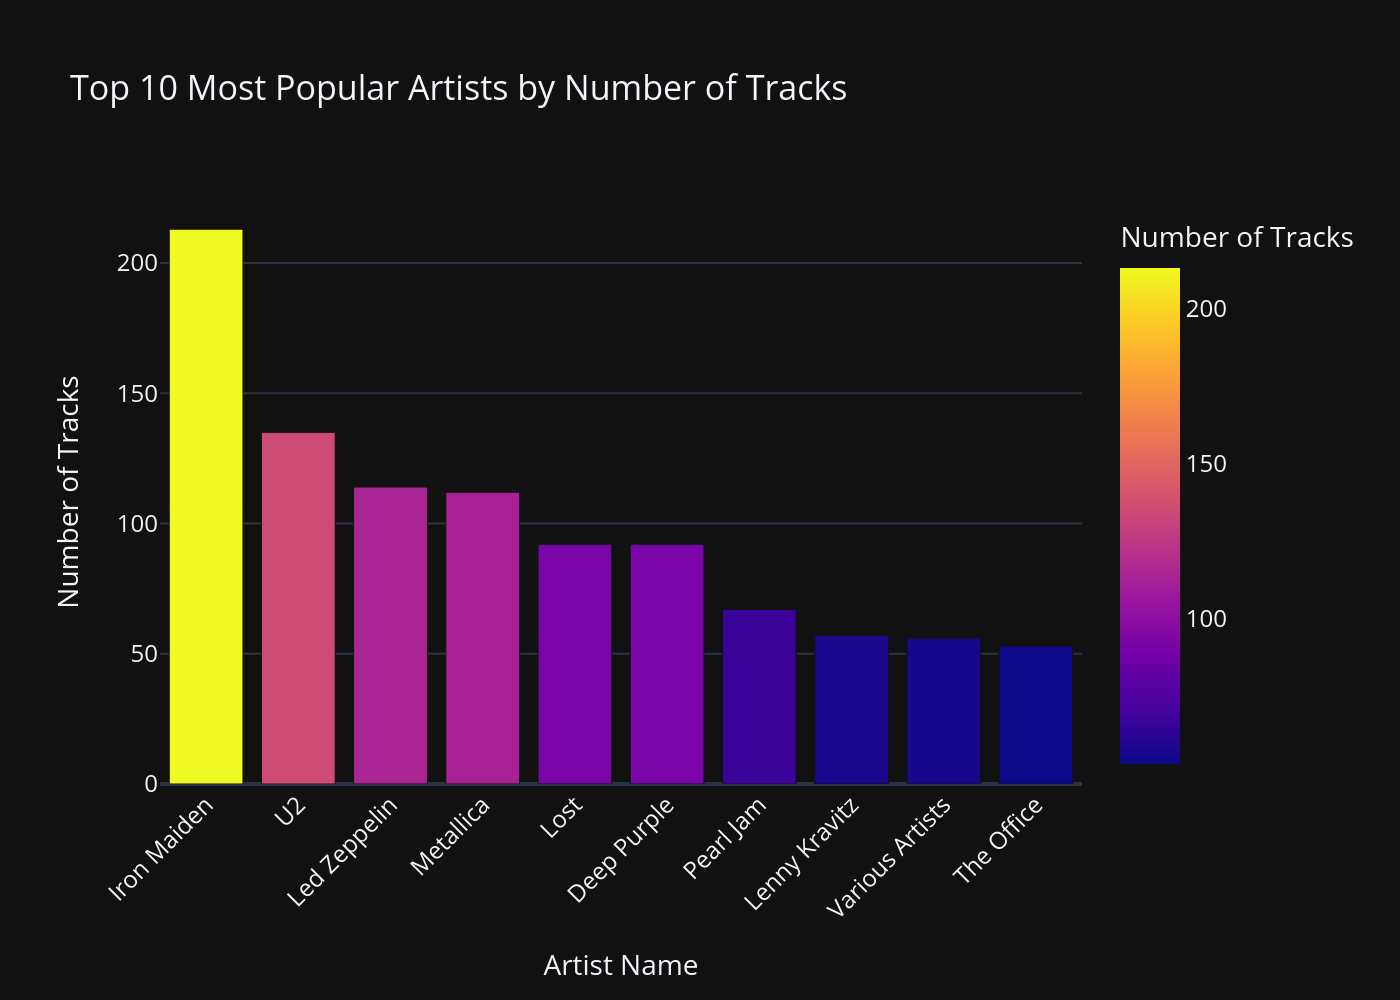





# QUESTION  - 19:  List all customers from Canada and their email addresses:



[( EXTRACTED SQL )]
SELECT
  FirstName,
  LastName,
  Email
FROM customers
WHERE
  Country = 'Canada';


[( <SQL> )]
generated SQL statement



SELECT
  FirstName,
  LastName,
  Email
FROM customers
WHERE
  Country = 'Canada';


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,Email
0,François,Tremblay,ftremblay@gmail.com
1,Mark,Philips,mphilips12@shaw.ca
2,Jennifer,Peterson,jenniferp@rogers.ca
3,Robert,Brown,robbrown@shaw.ca
4,Edward,Francis,edfrancis@yachoo.ca
5,Martha,Silk,marthasilk@gmail.com
6,Aaron,Mitchell,aaronmitchell@yahoo.ca
7,Ellie,Sullivan,ellie.sullivan@shaw.ca



[( <Python> )]
generated Plotly code



import pandas as pd
import plotly.graph_objects as go

# Limit data to 20 rows if necessary
if len(df) > 20:
    df_display = df.head(20)
else:
    df_display = df

# Check if there is only one value in the dataframe
if df_display.size == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df_display.iloc[0, 0],
        title={"text": df_display.columns[0]}
    ))
else:
    # Create a table chart for tabular data
    fig = go.Figure(data=[go.Table(
        header=dict(values=list(df_display.columns),
                    fill_color='paleturquoise',
                    align='left'),
        cells=dict(values=[df_display[col] for col in df_display.columns],
                   fill_color='lavender',
                   align='left'))
    ])

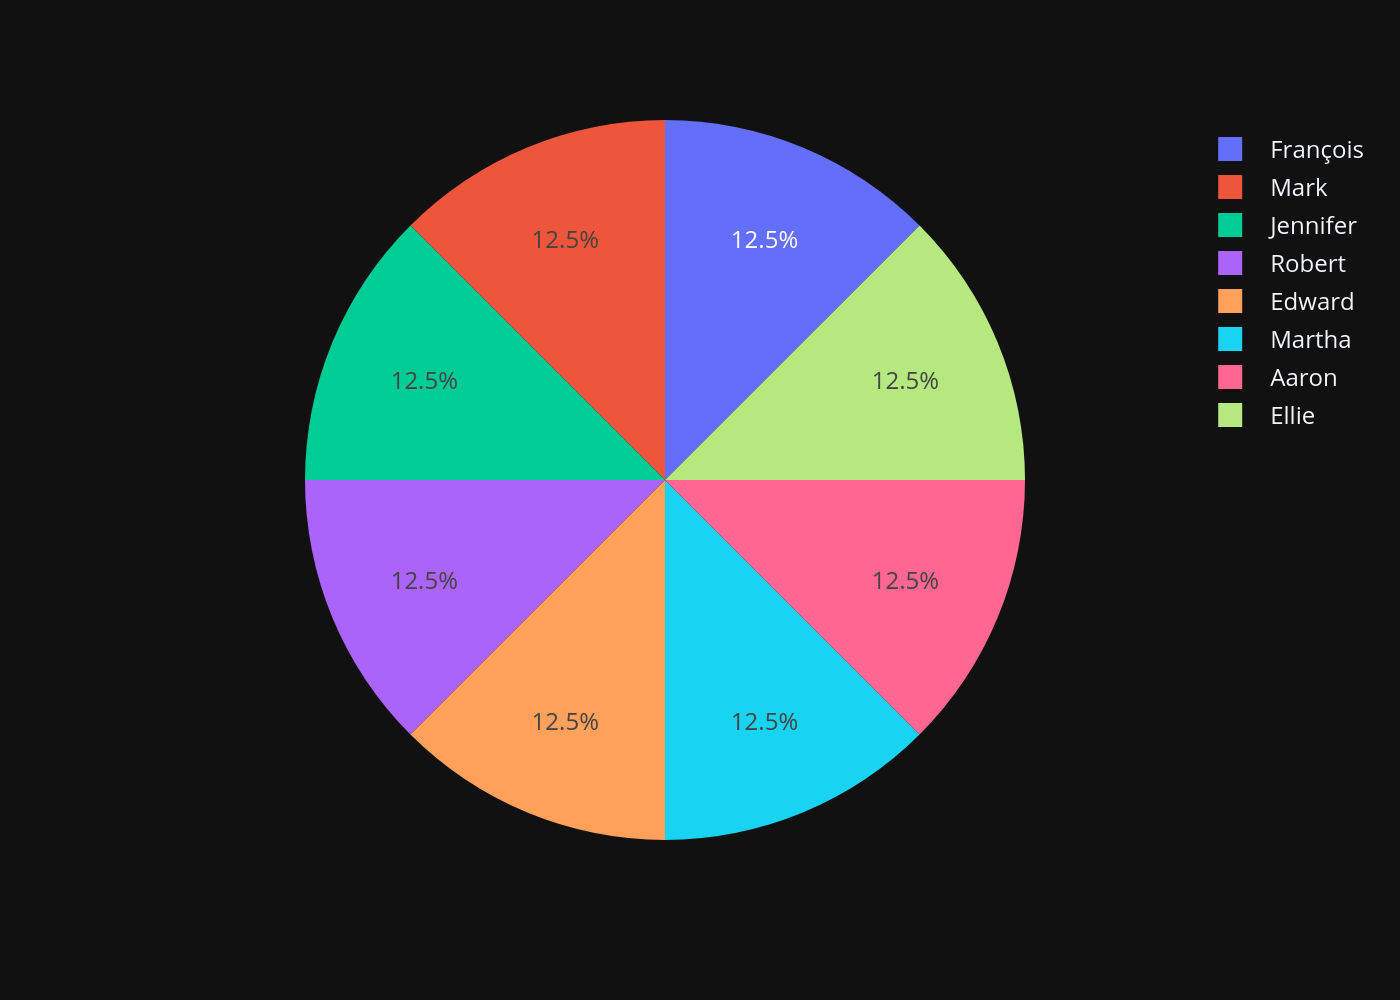





# QUESTION  - 20:  Find the customer with the most invoices 



[( EXTRACTED SQL )]
SELECT
  T1.FirstName,
  T1.LastName,
  COUNT(T2.InvoiceId) AS NumberOfInvoices
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName
ORDER BY
  NumberOfInvoices DESC
LIMIT 1;


[( <SQL> )]
generated SQL statement



SELECT
  T1.FirstName,
  T1.LastName,
  COUNT(T2.InvoiceId) AS NumberOfInvoices
FROM customers AS T1
INNER JOIN invoices AS T2
  ON T1.CustomerId = T2.CustomerId
GROUP BY
  T1.CustomerId,
  T1.FirstName,
  T1.LastName
ORDER BY
  NumberOfInvoices DESC
LIMIT 1;


[( <DataFrame> )]
queried dataframe



,FirstName,LastName,NumberOfInvoices
0,Luís,Gonçalves,7



[( RETRY )]
***** 1 *****

[ERROR-SQL] Failed to generate SQL for prompt: 
                    Generating SQL for this question: Find the customer with the most invoices 
                    results in the following error: [ERROR-VIZ] Failed to generate plotly code:
 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 10
}
] .
                    Can you try to fix the error and re-generate the SQL statement?
                 with the following exception: 
429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
}
, links {
  description: "Learn more about Gemini API 

In [18]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

## Check completion time

In [19]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'gemini-2.5-flash-preview-05-20' 
 took 231 sec
 run on 'papa-game' 
 at 20250525-232410


In [20]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-gemini-2.5-flash-preview-05-20-231s-papa-game-20250525-232410.csv'

### Save training data

In [21]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,dataset,question,content,training_data_type
0,29a795c2-f536-548c-85b1-494e94c547c4-ddl,default,None,"CREATE TABLE ""albums""\r\n(\r\n AlbumId INTE...",ddl
1,4ce614e1-1af5-502f-a106-5c71bd49c66c-ddl,default,None,"CREATE TABLE sqlite_sequence(name,seq)",ddl
2,981a8f6a-292e-5da4-b8f6-c979b05f60b2-ddl,default,None,"CREATE TABLE ""artists""\r\n(\r\n ArtistId IN...",ddl
3,90d6de66-fbf7-52fd-bf7d-c39796669b7f-ddl,default,None,"CREATE TABLE ""customers""\r\n(\r\n CustomerI...",ddl
4,1323a585-b921-528b-a12c-54697d3801d3-ddl,default,None,"CREATE TABLE ""employees""\r\n(\r\n EmployeeI...",ddl
5,a8d77d80-5afb-5178-8491-a4ed1eb6112d-ddl,default,None,"CREATE TABLE ""genres""\r\n(\r\n GenreId INTE...",ddl
6,0f11423b-66c8-5ba4-8e59-2e4f617db70e-ddl,default,None,"CREATE TABLE ""invoices""\r\n(\r\n InvoiceId ...",ddl
7,90be1638-159a-51d4-b376-762b805aae91-ddl,default,None,"CREATE TABLE ""invoice_items""\r\n(\r\n Invoi...",ddl
8,039a70d7-499f-57e5-9cff-73e7c23dd2b3-ddl,default,None,"CREATE TABLE ""media_types""\r\n(\r\n MediaTy...",ddl
9,02ee8d00-a7dd-5598-b62b-e3a06084dbda-ddl,default,None,"CREATE TABLE ""playlists""\r\n(\r\n PlaylistI...",ddl


In [22]:
df_training_data.to_csv(file_csv, index=False)